<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('data/')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

#### ПРИМЕЧАНИЕ: подготовленная функция работает как с готовым словарем, так и БЕЗ него

**_(старая версия этой функции, оставил для истории)_**

In [3]:
def prepare_train_set_with_fe_old(path_to_csv_files, site_freq_path=None, feature_names=None,
                                    session_length=10, window_size=None):
    ''' 
    Функция должна возвращать новый DataFrame.
    Признаки: site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id 
    '''
    # инициализация
    freq_vocabulary = {}
    data_mod = []    # модифицированный список закодированных сайтов с учетом окна
    data_timestamp = []
    data_timeindex = []
    data_hour = []
    data_weekday = []
    y = []
    
    if site_freq_path != None:            # если путь к словарю указан - считываем его
        # считываем частотный словарь
        with open(site_freq_path, 'rb') as pkl_file:
            freq_vocabulary = pickle.load(pkl_file)
    
    # подготовим пути для обхода и обойдем:
    for path in tqdm_notebook(glob(os.path.join(path_to_csv_files, 'user*.csv'))):
              
        # считаем файл с данными
        data_df = pd.read_csv(path, header=0, index_col=0)
        
        # если считан словарь - используем его для перекодировки, иначе - формируем словарь и параллельно перекодируем
        if site_freq_path != None:
            data = data_df['site'].apply(lambda x: freq_vocabulary[x][0])
        else:        
            ########################## сформируем словарь и перекодируем site_string в site_id
            data = []
            for site_string in data_df['site']:
                id_freq = freq_vocabulary.setdefault(site_string, [len(freq_vocabulary) + 1, 0])[0]
                freq_vocabulary[site_string][1] += 1
                data.append(id_freq)
        
        # рассчитаем число рядов (row) для текущего пользователя
        window_size_actual = window_size if window_size != None else session_length
        row = len(data) // window_size_actual + 1 if len(data) % window_size_actual != 0 \
                                                            else len(data) // window_size_actual
        
        #####################################################################################################
        # формирование сессий для текущих значений session_length и window_size
        def sessions_forming(data, row, session_length, window_size):
            data = list(data)
            if window_size != None:
                # добавляем нужное количество нанов (с ними удобнее, потом заменим нулями)
                data.extend([np.nan] * session_length)
                data_mod = []            
                for i in range(row):
                    data_mod.extend(data[(window_size * i):(window_size * i + session_length)])
                    
            else:
                # добавляем нужное количество нанов (с ними удобнее, потом заменим нулями)
                n_ext = session_length - len(data) % session_length if len(data) % session_length !=0 else 0
                data.extend([np.nan] * n_ext)
                data_mod = data
            
            return data_mod
        ####################################################################################################### 
        # "выдергивание" первой колонки на фичу
        def features_one_col(data, row, session_length, window_size):
            window_size_actual = window_size if window_size != None else session_length
            data = data.values
            
            return  [data[w * window_size_actual] for w in range(row)]   
        #######################################################################################################
        
        # формируем и накапливаем модифицированный список закодированных сайтов с учетом окна
        data_mod_user_id = sessions_forming(data, row, session_length, window_size)
        data_mod.extend(data_mod_user_id)
                 
        # работаем с датой-временем
        data_df.index = data_df.index.to_datetime()
        data_df['timestamp'] = data_df.index
        data_df['timestamp'] = data_df['timestamp'].apply(pd.datetime.timestamp)
                
        # формируем и накапливаем блок с временными данными аналогично сайтовому блоку
        data_timestamp_id = sessions_forming(data_df['timestamp'], row, session_length, window_size)
        data_timestamp.extend(data_timestamp_id)
        
        # формируем и накапливаем данные по часу
        data_hour_id = features_one_col(data_df.index.hour, row, session_length, window_size)
        data_hour.extend(data_hour_id)
        
        # формируем и накапливаем данные по weekday
        data_weekday_id = features_one_col(data_df.index.weekday, row, session_length, window_size)
        data_weekday.extend(data_weekday_id)        
        
        # сформируем и накопим вектор y "ответов", то есть user_id
        user_id = int(path[-8:-4]) # id пользователя
        col_user_id = [user_id] * row # forming columns with user_id
        y.extend(col_user_id)
        
    # сформируем признаки site1, ... siteNN
    rows = len(data_mod) // session_length
#     print('rows =', rows)
    data_mod = np.array(data_mod)
    data_mod.resize((rows, session_length))
    data_mod_df = pd.DataFrame(data_mod, columns=['site' + str(i) for i in range(1, session_length + 1)])
    
#     print('len(data_mod_df) =', len(data_mod_df))
    # формируем time_diff (работа со timestamp)
    data_timestamp = np.array(data_timestamp)
    data_timestamp.resize((rows, session_length))
    data_timestamp_df = pd.DataFrame(data_timestamp)
       
    data_time_diff = np.zeros([rows, 1])
    for j in range(1, session_length):
        data_time_diff = np.hstack((data_time_diff, 
                                        (data_timestamp[:, j] - data_timestamp[:, j - 1]).reshape(rows, 1)))
    data_time_diff_df = pd.DataFrame(data_time_diff[:, 1:], columns=['time_diff' + str(i) 
                                                for i in range(1, session_length)])
    
    # собираем все вместе
    df = pd.concat([
                    data_mod_df,
                    data_time_diff_df, 
                   ], axis=1)
    
    # df['session_timespan'] = data_time_diff_df.sum(axis=1)   # альтернативный вариант
    df['session_timespan'] = data_timestamp_df.max(axis=1, skipna=True) - data_timestamp_df.min(axis=1, skipna=True)
    df['#unique_sites'] = data_mod_df.nunique(axis=1, dropna=True)
    
#     print('len(data_hour) =', len(data_hour))
    df['start_hour'] = data_hour
    
    df['day_of_week'] = data_weekday
    
    df['target'] = y
    
    if feature_names != None:
        df.columns = feature_names
    
    return df.fillna(0).astype(int)

**_АКТУАЛЬНАЯ ВЕРСИЯ ФУНКЦИИ_**

In [4]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path=None, feature_names=None,
                                    session_length=10, window_size=None):
    ''' 
    Функция должна возвращать новый DataFrame.
    Признаки: site1, ... site10, session_timespan, #unique_sites, start_hour, day_of_week и user_id 
    '''
    # инициализация
    freq_vocabulary = {}    # словарь id сайтов
    data_mod = []    # модифицированный список закодированных сайтов с учетом окна
    data_datetime = []   # базовые данные с метками времени для формирования из них всех остальных временных признаков
    y = []      # целевая переменная (id пользователей)
    
    if site_freq_path != None:            # если путь к словарю указан - считываем его
        # считываем частотный словарь
        with open(site_freq_path, 'rb') as pkl_file:
            freq_vocabulary = pickle.load(pkl_file)
    
    # подготовим пути для обхода и обойдем:
    for path in tqdm_notebook(glob(os.path.join(path_to_csv_files, 'user*.csv'))):
              
        # считаем файл с данными
        data_df = pd.read_csv(path, header=0)
        
        # если считан словарь - используем его для перекодировки, иначе - формируем словарь и параллельно перекодируем
        if site_freq_path != None:
            # перекодировка с готовым словарём
            data = data_df['site'].apply(lambda x: freq_vocabulary[x][0])
        else:        
            # сформируем словарь и перекодируем site_string в site_id
            data = []
            for site_string in data_df['site']:
                id_freq = freq_vocabulary.setdefault(site_string, [len(freq_vocabulary) + 1, 0])[0]
                freq_vocabulary[site_string][1] += 1
                data.append(id_freq)
        
        # рассчитаем число рядов (row) для текущего пользователя
        window_size_actual = window_size if window_size != None else session_length
        row = len(data) // window_size_actual + 1 if len(data) % window_size_actual != 0 \
                                                            else len(data) // window_size_actual
        
        ###################################################################################################################
        # формирование сессий для текущих значений session_length и window_size
        def sessions_forming(data, row, session_length, window_size):
            data = list(data)
            if window_size != None:
                # добавляем нужное количество нанов (с ними удобнее, потом заменим нулями)
                data.extend([np.nan] * session_length)
                data_mod = []            
                for i in range(row):
                    data_mod.extend(data[(window_size * i):(window_size * i + session_length)])
                    
            else:
                # добавляем нужное количество нанов (с ними удобнее, потом заменим нулями)
                n_ext = session_length - len(data) % session_length if len(data) % session_length !=0 else 0
                data.extend([np.nan] * n_ext)
                data_mod = data
            
            return data_mod
        ####################################################################################################################
        
        # формируем и накапливаем модифицированный список закодированных сайтов с учетом окна
        data_mod_user_id = sessions_forming(data, row, session_length, window_size)
        data_mod.extend(data_mod_user_id)
                                 
        # формируем и накапливаем блок с временными данными аналогично сайтовому блоку
        data_datetime_id = sessions_forming(data_df['timestamp'].apply(pd.to_datetime), 
                                             row, session_length, window_size)
        data_datetime.extend(data_datetime_id)
                
        # сформируем и накопим вектор y "ответов", то есть user_id
        user_id = int(path[-8:-4]) # id пользователя
        col_user_id = [user_id] * row # forming columns with user_id
        y.extend(col_user_id)
        
    # расчитаем общее количество рядов в признаках
    rows = len(data_mod) // session_length
    
    # сформируем признаки site1, ... siteNN
    data_mod = np.array(data_mod)
    data_mod.resize((rows, session_length))
    data_mod_df = pd.DataFrame(data_mod, columns=['site' + str(i) for i in range(1, session_length + 1)])
    
    # формируем датафрейм с datetime (базовые данные для работа с временными метками)
    data_datetime = np.array(data_datetime)
    data_datetime.resize((rows, session_length))
    data_datetime_df = pd.DataFrame(data_datetime, columns=['datetime' + str(i) for i in range(1, session_length + 1)])

    # датафрейм с timestamp-метками
    data_timestamp_df = data_datetime_df.applymap(lambda x: pd.datetime.timestamp(x) 
                                                  if type(x) == pd._libs.tslib.Timestamp else np.nan)
    
    ###################### начинаем готовить датафрейм с признаками на выдачу    
    df = pd.DataFrame()
    
    # колонки с сайтами
    df[['site' + str(i) for i in range(1, session_length + 1)]] = \
                                    data_mod_df[['site' + str(i) for i in range(1, session_length + 1)]]
    
    # колонки с дельтой между заходами на сайты внутри сессии
    for j in range(1, session_length):
        df['time_diff' + str(j)] = data_timestamp_df.iloc[:, j] - data_timestamp_df.iloc[:, j - 1]

    # остальные признаки
    df['session_timespan'] = data_timestamp_df.max(axis=1, skipna=True) - data_timestamp_df.min(axis=1, skipna=True)
    df['#unique_sites'] = data_mod_df[['site' + str(i) for i in range(1, session_length + 1)]].nunique(axis=1, dropna=True)
    df['start_hour'] = data_datetime_df['datetime1'].apply(lambda x: x.hour)
    df['day_of_week'] = data_datetime_df['datetime1'].apply(lambda x: x.weekday())
    
    df['target'] = y # целевая переменная
    
    if feature_names != None:
        df = df[feature_names]
    
    return df.fillna(0).astype(int)

**Проверим функцию на игрушечном примере.**

In [5]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
        
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10, window_size=10)

A Jupyter Widget

In [6]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      2      2      3      2      4      5      6      7       8   
1      1      4      4      4      0      0      0      0      0       0   
2      1      2      9      9      2      0      0      0      0       0   
3     10      4      2      4      2      4      4      6     11      10   
4     10      4      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

#### (авторский проверочный вариант:)

In [7]:
train_data_toy

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      2      2      3      2      4      5      6      7       8   
1      1      4      4      4      0      0      0      0      0       0   
2      1      2      9      9      2      0      0      0      0       0   
3     10      4      2      4      2      4      4      6     11      10   
4     10      4      2      0      0      0      0      0      0       0   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0         287        1184        6278         186           2           1   
1           2           3          55           0           0           0   
2         287        1184        6278         186           0           0   
3         287        1184        6278         186           2           1   
4         287        1184           0           0           0           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           2           3          55              7998              8   
1           0           0           0                60              2   
2           0           0           0              7935              3   
3           2           3          55              7998              5   
4           0           0           0              1471              3   

   start_hour  day_of_week  target  
0           9            4       1  
1          12            4       1  
2           9            4       2  
3           9            4       3  
4          12            4       3

**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [8]:
%%time
train_data_10users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '10users'), 
                     site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_10users.pkl'),
                     feature_names=feature_names, session_length=10)

A Jupyter Widget


Wall time: 17.3 s


In [9]:
train_data_10users.head()

site1  site2  site3  site4  site5  site6  site7  site8  site9  site10  \
0      1      2      3      4      3      3      4      3      5       3   
1      6      7      8      9      3     10     11     12     13      14   
2     14      4     14     14     15     16      6     17     18      14   
3     19     20     19     14     14     14     14     21     22      23   
4     24     14     15     25     26     27     28     29     30      29   

   time_diff1  time_diff2  time_diff3  time_diff4  time_diff5  time_diff6  \
0          10           0           0           1          20           1   
1           1           0         163         105           0           1   
2           0          14           1         242           0           0   
3           2           1           0           1          25           1   
4           1           0           1           1           1           0   

   time_diff7  time_diff8  time_diff9  session_timespan  #unique_sites  \
0           0           1           0                33              5   
1           3           3           8               284             10   
2           1           0           0               258              7   
3           0           0           0                30              6   
4           1           1           0                 6              9   

   start_hour  day_of_week  target  
0           8            4      31  
1           8            4      31  
2           8            4      31  
3           8            4      31  
4           8            4      31

**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [10]:
%%time
train_data_150users = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '150users'), 
                      site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_150users.pkl'),
                      feature_names=feature_names, session_length=10)

A Jupyter Widget


Wall time: 2min 45s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [11]:
new_features_10users = train_data_10users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]
new_features_150users = train_data_150users[['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']]

In [12]:
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 
                       'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, потехи для дадим пользователям имена и ассоциируем с ними цвета.**

In [13]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['user_id'] = train_data_10users['target'].map(id_name_dict)

In [14]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

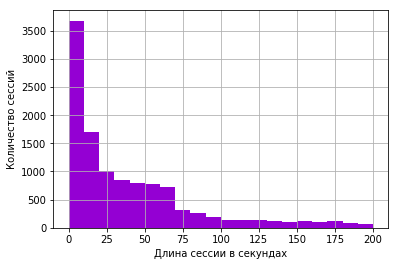

In [15]:
train_data_10users['session_timespan'][train_data_10users['session_timespan'] <= 200].hist(color='darkviolet', bins=20)
plt.xlabel('Длина сессии в секундах')
plt.ylabel('Количество сессий');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

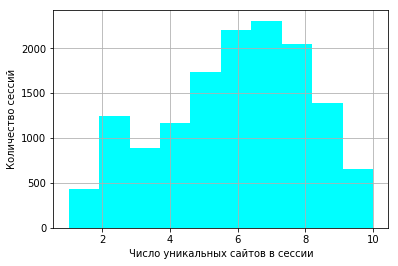

In [16]:
train_data_10users['#unique_sites'].hist(color='aqua', bins=10)
plt.xlabel('Число уникальных сайтов в сессии')
plt.ylabel('Количество сессий');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

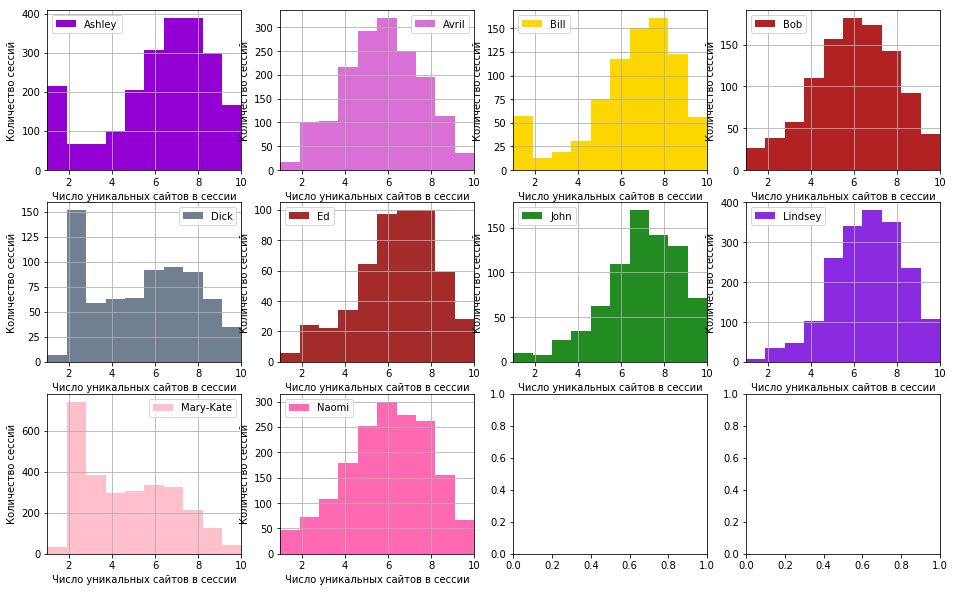

In [17]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    col = '#unique_sites'
    sub_df[col].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user,
                               bins=(sub_df[col].max() - sub_df[col].min() + 1))
    axes[idx // 4, idx % 4].legend()
    axes[idx // 4, idx % 4].set_xlim([1, 10])
    axes[idx // 4, idx % 4].set_xlabel('Число уникальных сайтов в сессии')
    axes[idx // 4, idx % 4].set_ylabel('Количество сессий')

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

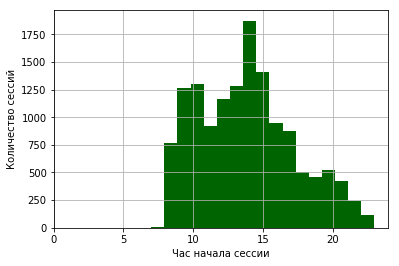

In [18]:
train_data_10users['start_hour'].hist(color='darkgreen', 
                                      bins=(sub_df['start_hour'].max() - sub_df['start_hour'].min() + 1))
plt.xlim([0, 24])
plt.xlabel('Час начала сессии')
plt.ylabel('Количество сессий');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

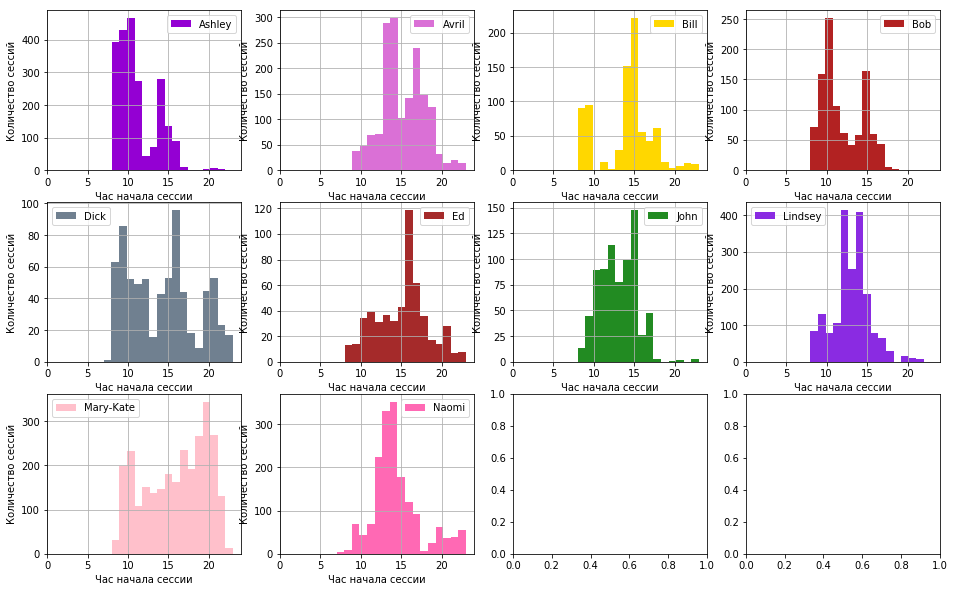

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')): 
    col = 'start_hour'
    sub_df[col].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user,
                               bins=(sub_df[col].max() - sub_df[col].min() + 1))
    axes[idx // 4, idx % 4].legend()
    axes[idx // 4, idx % 4].set_xlim([0, 24])
    axes[idx // 4, idx % 4].set_xlabel('Час начала сессии')
    axes[idx // 4, idx % 4].set_ylabel('Количество сессий')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

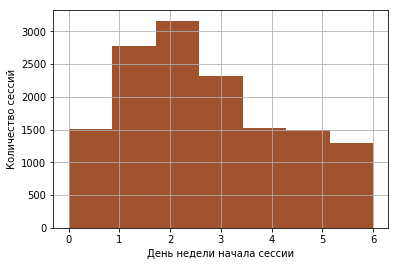

In [20]:
train_data_10users['day_of_week'].hist(color='sienna', bins=7)
#plt.xlim([-0, 6])
plt.xlabel('День недели начала сессии')
plt.ylabel('Количество сессий');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

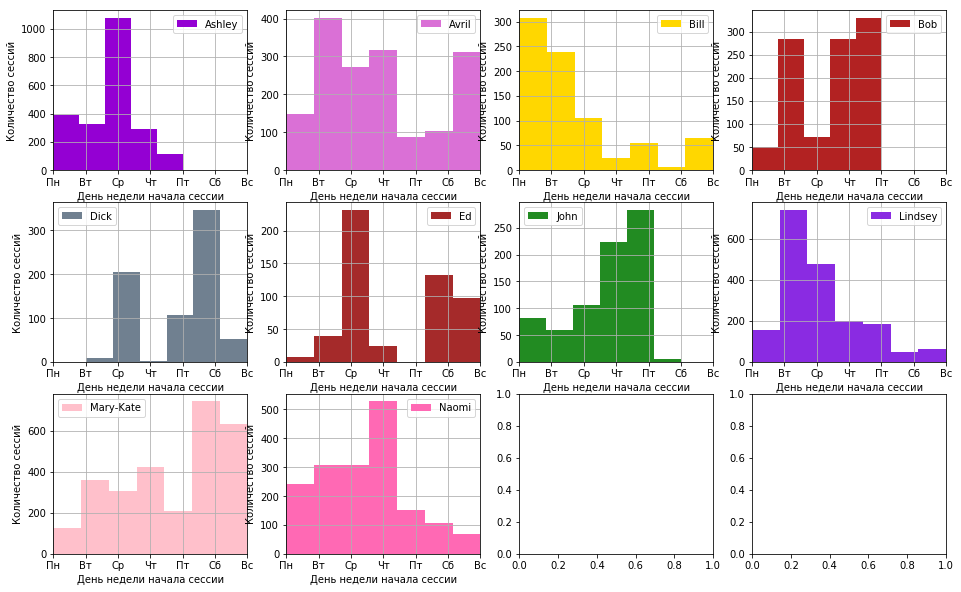

In [21]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(train_data_10users, 'user_id')):
    col = 'day_of_week'
    sub_df[col].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user,
                               bins=(sub_df[col].max() - sub_df[col].min() + 1))
    axes[idx // 4, idx % 4].legend()
    axes[idx // 4, idx % 4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
    axes[idx // 4, idx % 4].set_xlim([0, 6])
    axes[idx // 4, idx % 4].set_xlabel('День недели начала сессии')
    axes[idx // 4, idx % 4].set_ylabel('Количество сессий')

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

Распределения рассмотренных выше величин для пользователей **различаются** и могут служить в соответствующей степени их **характеристиками**. 
- В частности, сравнивая визуально гистограмму распределения числа уникальных сайтов в сессии (**#unique_sites**) с соответствущими распределениями отдельных пользователей видно, что **отдельные распределения отличаются от усредненного**. Усредненное имеет глобальный пик **на 7** и **локальный пик на 2**, в то время как для локальных имеет место:
    - **Ashley**: пик на 1 и 8

    - **Avril**: пик на 6

    - **Bill**: пик на 1 и 8

    - **Bob**: пик на 6

    - **Dick**: пик на 2 и 7 (слабо выраженый)

    - **Ed**: пик на 7

    - **John**: пик на 7

    - **Lindsey**: пик на 7

    - **Mary-Kate**: пик на 2

    - **Naomi**: пик на 6


- аналогично, сравнивая визуально гистограмму распределения часа начала сессии (**start_hour**) с соответствущими распределениями отдельных пользователей видно, что **отдельные распределения отличаются от усредненного**. Усредненное имеет глобальный пик **на 14** и **локальный пик на 10**, в то время как для локальных имеет место:
    - **Ashley**: пик на 10 и 14

    - **Avril**: пик на 13 и 17

    - **Bill**: пик на 9 и 15

    - **Bob**: пик на 10 и 15

    - **Dick**: 3 пика - на 10, 14 и 21

    - **Ed**: пик на 16

    - **John**: пик на 12 и 15

    - **Lindsey**: пик на 12 и 14

    - **Mary-Kate**: пик на 10 и 19

    - **Naomi**: пик на 14


- и то же справедливо для дня начала сессии (**day_of_week**): усредненное распределение (**пик на 2**) достаточно сильно отличается от распределений индивидуальных пользователей:
    - **Ashley**: пик на ср.    

    - **Avril**: пик на вт. и вс.

    - **Bill**: пик на пн.

    - **Bob**: пик на вт. и пт.

    - **Dick**: пик на ср. и сб.

    - **Ed**: пик на ср. и сб.

    - **John**: пик на пт (выходные - провал)

    - **Lindsey**: пик на вт.

    - **Mary-Kate**: пик на выходные

    - **Naomi**: пик на чт.


**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей. **

In [22]:
with open(os.path.join(PATH_TO_DATA,'site_freq_10users.pkl'), 'rb') as pkl_file:
        site_freq_10users = pickle.load(pkl_file)

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [23]:
top10_freqs = list(map(lambda x: x[1][1], sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)))[:10]
top10_sites = list(map(lambda x: x[0], sorted(site_freq_10users.items(), key=lambda x: x[1][1], reverse=True)))[:10]

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

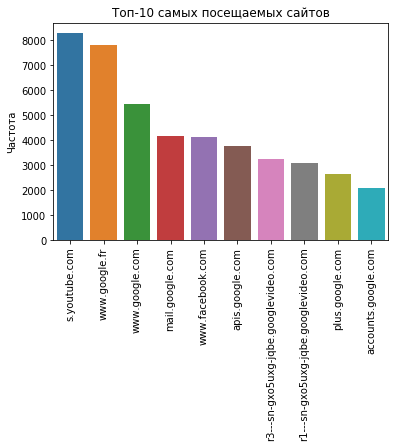

In [24]:
sns.barplot(top10_sites, top10_freqs)
plt.title('Топ-10 самых посещаемых сайтов')
plt.ylabel('Частота')
plt.xticks(rotation=90);

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [25]:
print('Медианная продолжительность сессии для 10 пользователей: \n{}'
      .format(train_data_10users['session_timespan'].median()))

Медианная продолжительность сессии для 10 пользователей: 
37.0


**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [26]:
print('Медианный день недели, в который началась сессия, для 10 пользователей: \n{}'
      .format(train_data_10users['day_of_week'].median()))

Медианный день недели, в который началась сессия, для 10 пользователей: 
2.0


**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [27]:
print('Медианный час начала сессии для 150 пользователей: \n{}'
      .format(train_data_150users['start_hour'].median()))

Медианный час начала сессии для 150 пользователей: 
13.0


**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [28]:
print('Медианное значение числа уникальных сайтов в сессиях 150 пользователей: \n{}'
      .format(train_data_150users['#unique_sites'].median()))

Медианное значение числа уникальных сайтов в сессиях 150 пользователей: 
7.0


## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [29]:
def feature_engineering(path_to_csv_files, site_freq_path=None, feature_names=None, 
                        old_features=False, session_length=10, window_size=None):
    ''' 
    Возвращает Датафрейм с фичами.
    
    path_to_csv_files - путь к папке с сессиями пользователей.
    
    site_freq_path - путь к готовому словарю. Если None - словарь создается по-новому.
    
    feature_names - список выводимых фич. Если None - выводятся все рассчитанные фичи. 
        Этот список может содержать только следующие элементы:
            новые фичи - 
        ['start_year', 'start_month', 'start_day', 'time_of_day', 'mean_site_time',
         'freq_top30_0_4', 'freq_top30_1_2', 'freq_top30_2_1', ...(и т.д. по всем топ30 сайтов, 
         последняя цифра в названии элемента - код сайта, может меняться),
         'weekend']
           
           старые фичи (выводятся только если old_features=True) -
       ['site1', 'site2', 'site3', 'site4', 'site5', 'site6', 'site7', 'site8', 'site9', 'site10',
       'time_diff1', 'time_diff2', 'time_diff3', 'time_diff4', 'time_diff5',
       'time_diff6', 'time_diff7', 'time_diff8', 'time_diff9',
       'session_timespan', '#unique_sites', 'start_hour', 'day_of_week',
       'target']
    
    old_features - выводить или не выводить старые фичи.
    
    session_length - размер сессии.
    
    window_size - размер окна. Если None - окна как такового нет, все режется только на сессии (аналогично 
        как если бы window_size = session_length)
    
    '''
    # инициализация
    freq_vocabulary = {}    # словарь id сайтов
    data_mod = []    # модифицированный список закодированных сайтов с учетом окна
    data_datetime = []   # базовые данные с метками времени для формирования из них всех остальных временных признаков
    y = []      # целевая переменная (id пользователей)
    
    if site_freq_path != None:            # если путь к словарю указан - считываем его
        # считываем частотный словарь
        with open(site_freq_path, 'rb') as pkl_file:
            freq_vocabulary = pickle.load(pkl_file)
    
    # подготовим пути для обхода и обойдем:
    for path in tqdm_notebook(glob(os.path.join(path_to_csv_files, 'user*.csv'))):
              
        # считаем файл с данными
        data_df = pd.read_csv(path, header=0)
        
        # если считан словарь - используем его для перекодировки, иначе - формируем словарь и параллельно перекодируем
        if site_freq_path != None:
            # перекодировка с готовым словарём
            data = data_df['site'].apply(lambda x: freq_vocabulary[x][0])
        else:        
            # сформируем словарь и перекодируем site_string в site_id
            data = []
            for site_string in data_df['site']:
                id_freq = freq_vocabulary.setdefault(site_string, [len(freq_vocabulary) + 1, 0])[0]
                freq_vocabulary[site_string][1] += 1
                data.append(id_freq)
        
        # рассчитаем число рядов (row) для текущего пользователя
        window_size_actual = window_size if window_size != None else session_length
        row = len(data) // window_size_actual + 1 if len(data) % window_size_actual != 0 \
                                                            else len(data) // window_size_actual
        
        ###################################################################################################################
        # формирование сессий для текущих значений session_length и window_size
        def sessions_forming(data, row, session_length, window_size):
            data = list(data)
            if window_size != None:
                # добавляем нужное количество нанов (с ними удобнее, потом заменим нулями)
                data.extend([np.nan] * session_length)
                data_mod = []            
                for i in range(row):
                    data_mod.extend(data[(window_size * i):(window_size * i + session_length)])
                    
            else:
                # добавляем нужное количество нанов (с ними удобнее, потом заменим нулями)
                n_ext = session_length - len(data) % session_length if len(data) % session_length !=0 else 0
                data.extend([np.nan] * n_ext)
                data_mod = data
            
            return data_mod
        ####################################################################################################################
        
        # формируем и накапливаем модифицированный список закодированных сайтов с учетом окна
        data_mod_user_id = sessions_forming(data, row, session_length, window_size)
        data_mod.extend(data_mod_user_id)
                                 
        # формируем и накапливаем блок с временными данными аналогично сайтовому блоку
        data_datetime_id = sessions_forming(data_df['timestamp'].apply(lambda x: pd.to_datetime(x)), 
                                             row, session_length, window_size)
        data_datetime.extend(data_datetime_id)
                
        # сформируем и накопим вектор y "ответов", то есть user_id
        user_id = int(path[-8:-4]) # id пользователя
        col_user_id = [user_id] * row # forming columns with user_id
        y.extend(col_user_id)
        
    # рассчитаем общее количество рядов в признаках
    rows = len(data_mod) // session_length
    
    # сформируем признаки site1, ... siteNN
    data_mod = np.array(data_mod)
    data_mod.resize((rows, session_length))
    data_mod_df = pd.DataFrame(data_mod, columns=['site' + str(i) for i in range(1, session_length + 1)])
    
    # формируем датафрейм с datetime (базовые данные для работа с временными метками)
    data_datetime = np.array(data_datetime)
    data_datetime.resize((rows, session_length))
    data_datetime_df = pd.DataFrame(data_datetime, columns=['datetime' + str(i) for i in range(1, session_length + 1)])

    # датафрейм с timestamp-метками
    data_timestamp_df = data_datetime_df.applymap(lambda x: pd.datetime.timestamp(x) 
                                                  if type(x) == pd._libs.tslib.Timestamp else np.nan)
    
    ###################### начинаем готовить датафрейм с признаками на выдачу   
    df = pd.DataFrame()
    
    # год начала сессии
    df['start_year'] = data_datetime_df['datetime1'].apply(lambda x: x.year)
    
    # месяц начала сессии
    df['start_month'] = data_datetime_df['datetime1'].apply(lambda x: x.month)
    
    # день начала сессии
    df['start_day'] = data_datetime_df['datetime1'].apply(lambda x: x.day)
    
    # время суток (06-12 - утро(1), 12-19 - день(2), 19-24 - вечер(3), 00-06 - ночь(4))
    df['time_of_day'] = data_datetime_df['datetime1'].apply(lambda x:  1 if x.hour >  6 and x.hour <= 12 else 
                                                                       2 if x.hour > 12 and x.hour <= 19 else
                                                                       3 if x.hour > 19 and x.hour <= 24 else
                                                                       4)
    
    # среднее время пребывания на сайте для топ-30 популярных сайтов (усредненное по всем топ-30)
    top30_sites_id = list(map(lambda x: x[1][0], sorted(freq_vocabulary.items(), key=lambda x: x[1][1], reverse=True)))[:30]
    top30_index = data_mod_df.iloc[:, :-1].applymap(lambda x: x in top30_sites_id)
    top30_index.columns = ['time_diff' + str(j) for j in range(1, session_length)]
    
    time_diff_df = pd.DataFrame()
    for j in range(1, session_length):
        time_diff_df['time_diff' + str(j)] = data_timestamp_df.iloc[:, j] - data_timestamp_df.iloc[:, j - 1]
        
    df['mean_site_time'] = time_diff_df[top30_index].mean(axis=1, skipna=True)
    
    # частота посещения топ-30 популярных сайтов
    for i, id_ in enumerate(top30_sites_id):
        df['freq_top30_{}_{}'.format(i, id_)] = data_mod_df.applymap(lambda x: x == id_).sum(axis=1)
        
    # индикатор уикэнда в день начала сессии
    df['weekend'] = data_datetime_df['datetime1'].apply(lambda x: 1 if x.weekday() in [5, 6] else 0)
   
    #################### блок со СТАРЫМИ фичами
    if old_features:     
        # колонки с сайтами
        df[['site' + str(i) for i in range(1, session_length + 1)]] = \
                                       data_mod_df[['site' + str(i) for i in range(1, session_length + 1)]]

        # колонки с дельтой между заходами на сайты внутри сессии
        df = pd.concat([df, time_diff_df], axis=1)
#         for j in range(1, session_length):
#             df['time_diff' + str(j)] = data_timestamp_df.iloc[:, j] - data_timestamp_df.iloc[:, j - 1]

        # остальные признаки
        df['session_timespan'] = data_timestamp_df.max(axis=1, skipna=True) - data_timestamp_df.min(axis=1, skipna=True)

        df['#unique_sites'] = data_mod_df[['site' + str(i) for i in range(1, session_length + 1)]].nunique(axis=1, dropna=True)

        df['start_hour'] = data_datetime_df['datetime1'].apply(lambda x: x.hour)

        df['day_of_week'] = data_datetime_df['datetime1'].apply(lambda x: x.weekday())


    df['target'] = y
    
    if feature_names != None:
        df = df[feature_names]

    return df.fillna(0).astype(int)

проверим на игрушечном примере

In [30]:
features_eng = feature_engineering(os.path.join(PATH_TO_DATA, '3users'), feature_names=None,  
                                   old_features=True, session_length=10, window_size=None)

A Jupyter Widget

In [31]:
features_eng

start_year  start_month  start_day  time_of_day  mean_site_time  \
0        2013           11         15            1             888   
1        2013           11         15            1              20   
2        2013           11         15            1            1983   
3        2013           11         15            1             888   
4        2013           11         15            1             735   

   freq_top30_0_4  freq_top30_1_2  freq_top30_2_1  freq_top30_3_10  \
0               1               3               1                0   
1               3               0               1                0   
2               0               2               1                0   
3               4               2               0                2   
4               1               1               0                1   

   freq_top30_4_6  freq_top30_5_9  freq_top30_6_3   ...    time_diff3  \
0               1               0               1   ...          6278   
1               0               0               0   ...            55   
2               0               2               0   ...          6278   
3               1               0               0   ...          6278   
4               0               0               0   ...             0   

   time_diff4  time_diff5  time_diff6  time_diff7  time_diff8  time_diff9  \
0         186           2           1           2           3          55   
1           0           0           0           0           0           0   
2         186           0           0           0           0           0   
3         186           2           1           2           3          55   
4           0           0           0           0           0           0   

   session_timespan  #unique_sites  start_hour  day_of_week  target  
0              7998              8           9            4       1  
1                60              2          12            4       1  
2              7935              3           9            4       2  
3              7998              5           9            4       3  
4              1471              3          12            4       3  

[5 rows x 41 columns]

#### Посчитаем новые фичи для 10 и 150 пользователей.

In [32]:
%%time
new_features_10users = feature_engineering(os.path.join(PATH_TO_DATA, '10users'))

A Jupyter Widget


Wall time: 17.9 s


In [33]:
new_features_10users.head()

start_year  start_month  start_day  time_of_day  mean_site_time  \
0        2013           11         15            1               0   
1        2013           11         15            1               0   
2        2013           11         15            1               7   
3        2013           11         15            1               0   
4        2013           11         15            1               1   

   freq_top30_0_210  freq_top30_1_51  freq_top30_2_4  freq_top30_3_183  \
0                 0                0               2                 0   
1                 0                0               0                 0   
2                 0                0               1                 0   
3                 0                0               0                 0   
4                 0                0               0                 0   

   freq_top30_4_15  freq_top30_5_52  freq_top30_6_700   ...    \
0                0                0                 0   ...     
1                0                0                 0   ...     
2                1                0                 0   ...     
3                0                0                 0   ...     
4                1                0                 0   ...     

   freq_top30_20_185  freq_top30_21_70  freq_top30_22_191  freq_top30_23_576  \
0                  0                 0                  0                  0   
1                  0                 0                  0                  0   
2                  0                 0                  0                  0   
3                  0                 0                  0                  0   
4                  0                 0                  0                  0   

   freq_top30_24_1026  freq_top30_25_1602  freq_top30_26_186  \
0                   0                   0                  0   
1                   0                   0                  0   
2                   0                   0                  0   
3                   0                   0                  0   
4                   0                   0                  0   

   freq_top30_27_1949  freq_top30_28_972  freq_top30_29_188  weekend  target  
0                   0                  0                  0        0      31  
1                   0                  0                  0        0      31  
2                   0                  0                  0        0      31  
3                   0                  0                  0        0      31  
4                   0                  0                  0        0      31  

[5 rows x 37 columns]

In [34]:
%%time
new_features_150users = feature_engineering(os.path.join(PATH_TO_DATA, '150users'))

A Jupyter Widget


Wall time: 2min 51s


In [35]:
new_features_150users.head()

start_year  start_month  start_day  time_of_day  mean_site_time  \
0        2013           11         15            1               7   
1        2013           11         15            1               0   
2        2013           11         15            1              16   
3        2013           11         15            1               2   
4        2013           11         15            1               2   

   freq_top30_0_1  freq_top30_1_3  freq_top30_2_41  freq_top30_3_2  \
0               4               2                0               2   
1               0               1                0               0   
2               5               1                0               0   
3               4               0                0               0   
4               3               0                0               0   

   freq_top30_4_181  freq_top30_5_214  freq_top30_6_28   ...    \
0                 0                 0                0   ...     
1                 0                 0                0   ...     
2                 0                 0                0   ...     
3                 0                 0                0   ...     
4                 0                 0                0   ...     

   freq_top30_20_182  freq_top30_21_1201  freq_top30_22_6  freq_top30_23_2165  \
0                  0                   0                0                   0   
1                  0                   0                1                   0   
2                  0                   0                0                   0   
3                  0                   0                0                   0   
4                  0                   0                0                   0   

   freq_top30_24_244  freq_top30_25_180  freq_top30_26_1463  \
0                  0                  0                   0   
1                  0                  0                   0   
2                  0                  0                   0   
3                  0                  0                   0   
4                  0                  0                   0   

   freq_top30_27_106  freq_top30_28_253  freq_top30_29_2707  weekend  target  
0                  0                  0                   0        0       6  
1                  0                  0                   0        0       6  
2                  0                  0                   0        0       6  
3                  0                  0                   0        0       6  
4                  0                  0                   0        0       6  

[5 rows x 37 columns]

#### Попробуем то же, но с другим окном:  
session_length=10, window_size=7

In [36]:
%%time
new_features_10users_s10_w7 = feature_engineering(os.path.join(PATH_TO_DATA, '10users'), session_length=10, window_size=7)

A Jupyter Widget


Wall time: 19.1 s


**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

Делаем на датасете по 10 пользователям.

In [37]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users['user_id'] = new_features_10users['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [38]:
new_features_10users.columns[:-2]

Index(['start_year', 'start_month', 'start_day', 'time_of_day',
       'mean_site_time', 'freq_top30_0_210', 'freq_top30_1_51',
       'freq_top30_2_4', 'freq_top30_3_183', 'freq_top30_4_15',
       'freq_top30_5_52', 'freq_top30_6_700', 'freq_top30_7_214',
       'freq_top30_8_187', 'freq_top30_9_184', 'freq_top30_10_699',
       'freq_top30_11_622', 'freq_top30_12_207', 'freq_top30_13_208',
       'freq_top30_14_568', 'freq_top30_15_1796', 'freq_top30_16_66',
       'freq_top30_17_63', 'freq_top30_18_205', 'freq_top30_19_72',
       'freq_top30_20_185', 'freq_top30_21_70', 'freq_top30_22_191',
       'freq_top30_23_576', 'freq_top30_24_1026', 'freq_top30_25_1602',
       'freq_top30_26_186', 'freq_top30_27_1949', 'freq_top30_28_972',
       'freq_top30_29_188', 'weekend'],
      dtype='object')

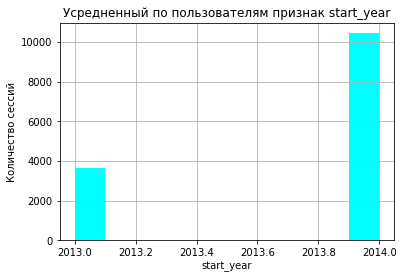

Распределение признака start_year для каждого пользователя


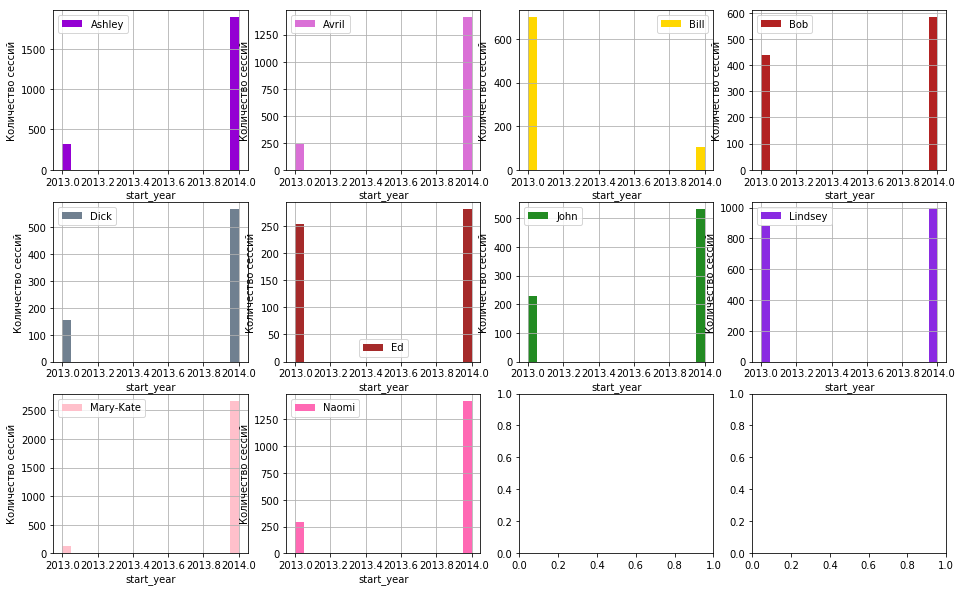

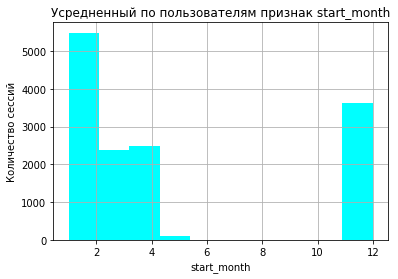

Распределение признака start_month для каждого пользователя


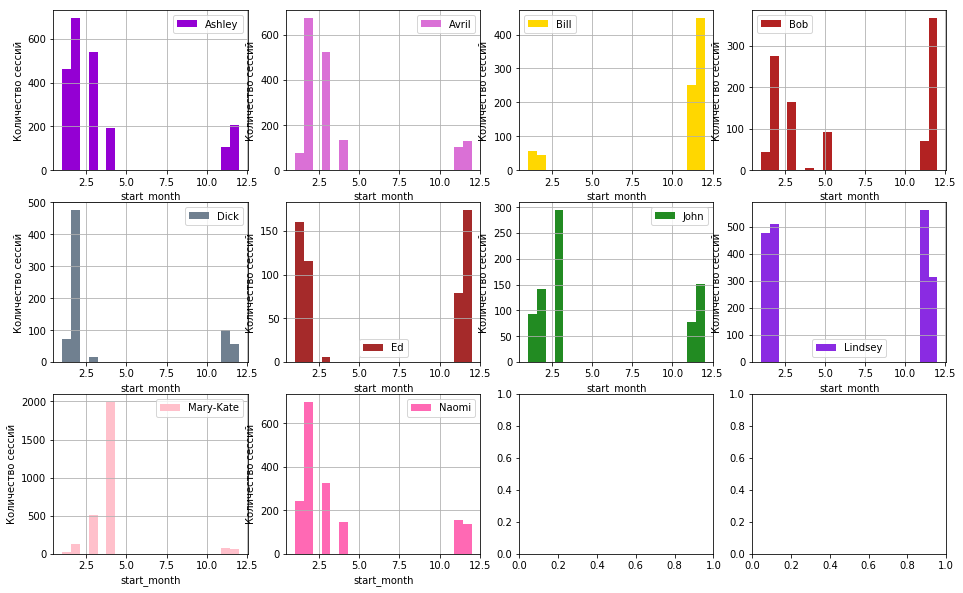

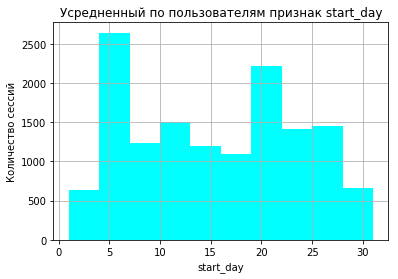

Распределение признака start_day для каждого пользователя


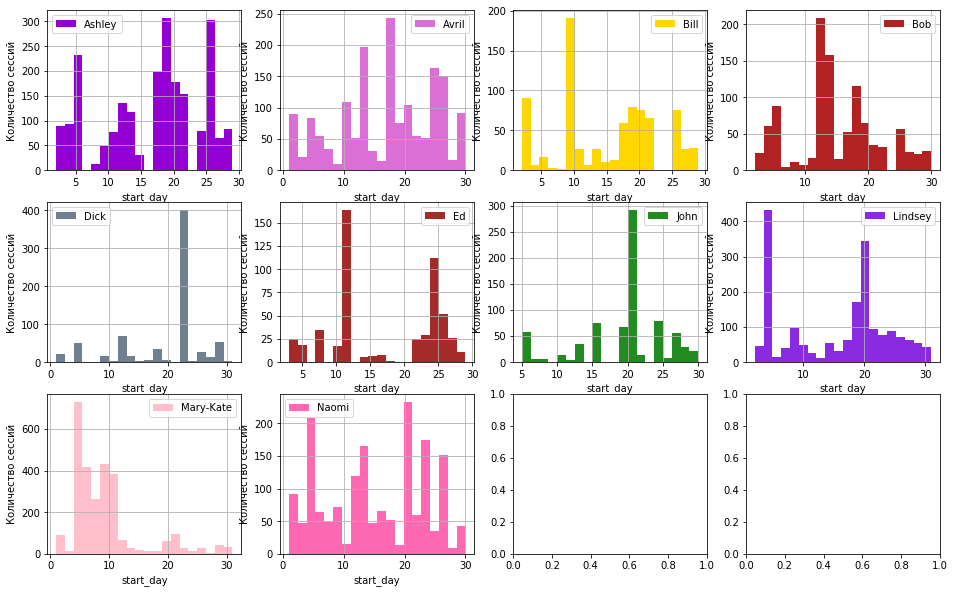

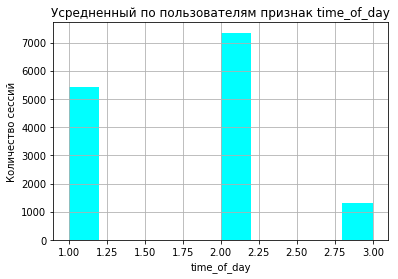

Распределение признака time_of_day для каждого пользователя


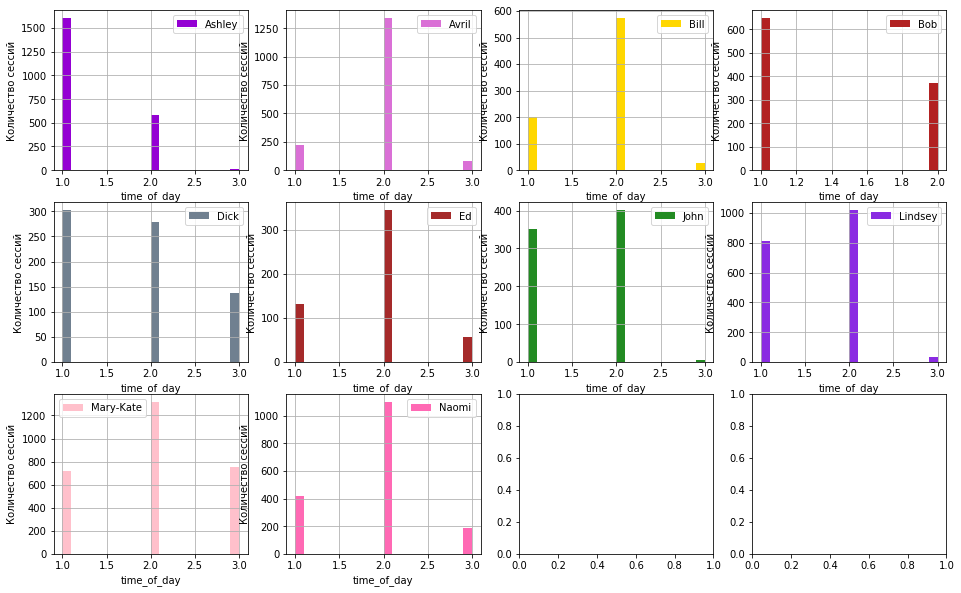

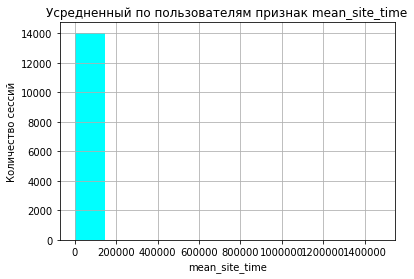

Распределение признака mean_site_time для каждого пользователя


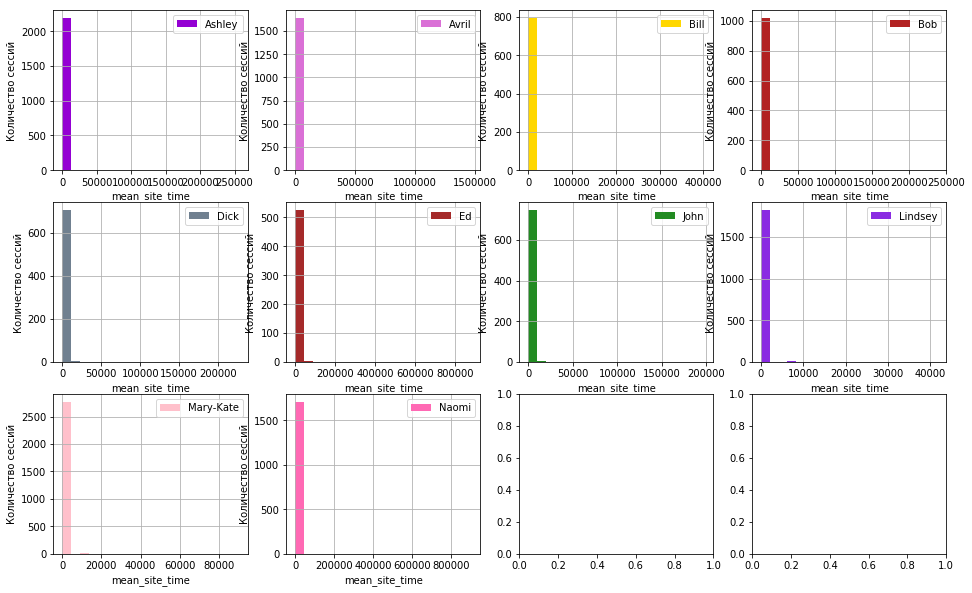

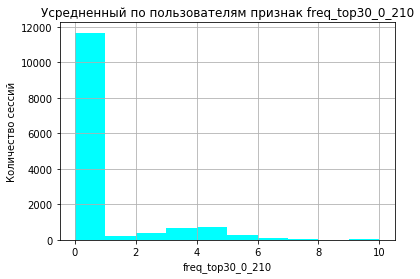

Распределение признака freq_top30_0_210 для каждого пользователя


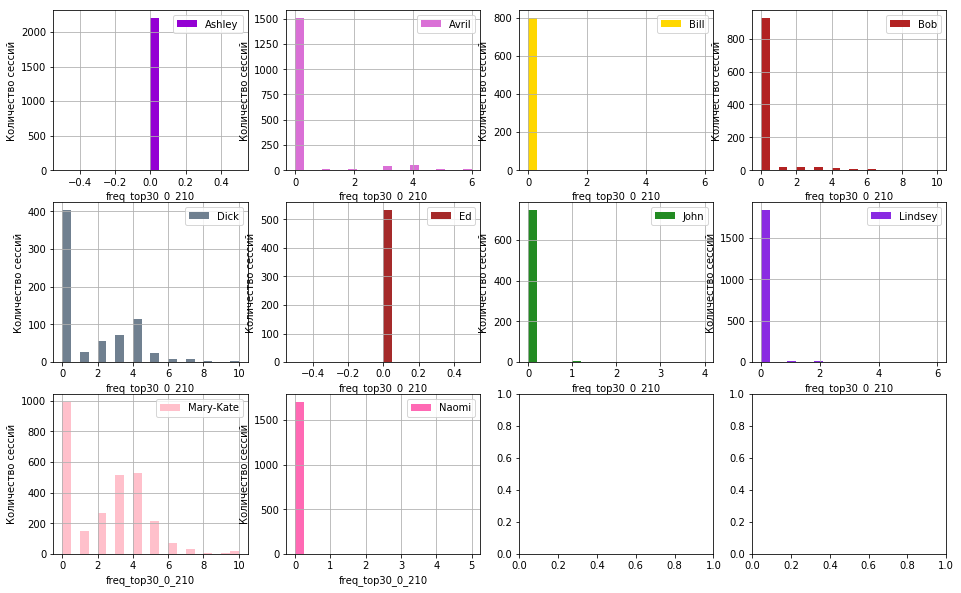

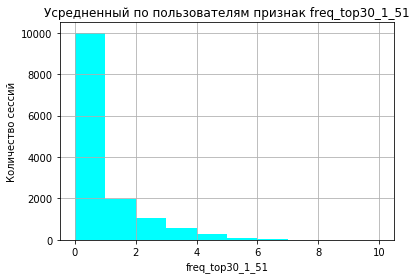

Распределение признака freq_top30_1_51 для каждого пользователя


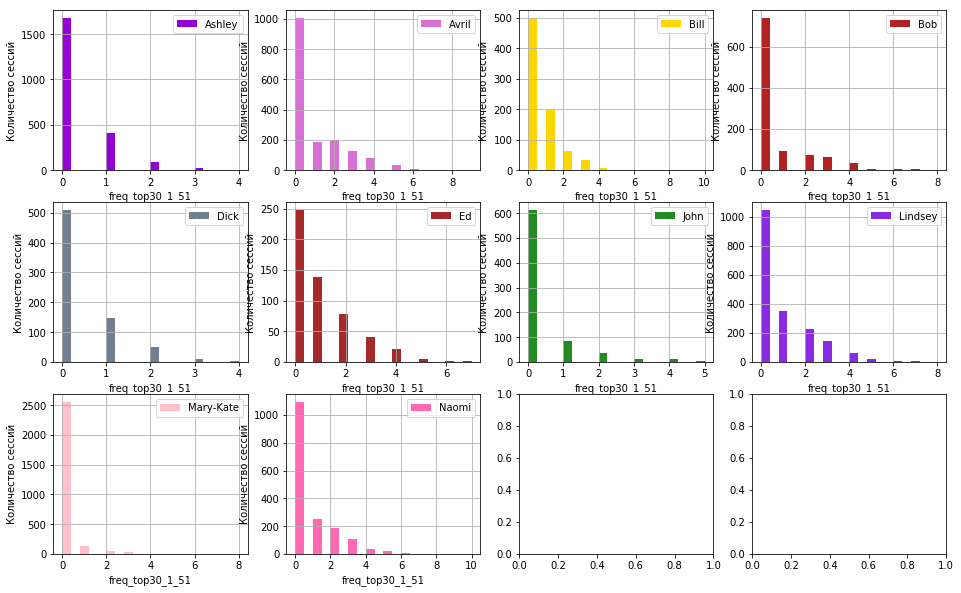

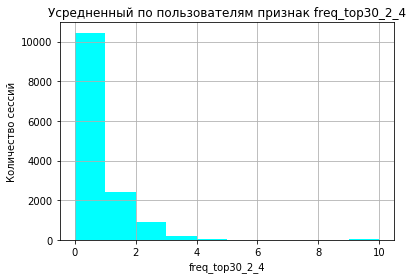

Распределение признака freq_top30_2_4 для каждого пользователя


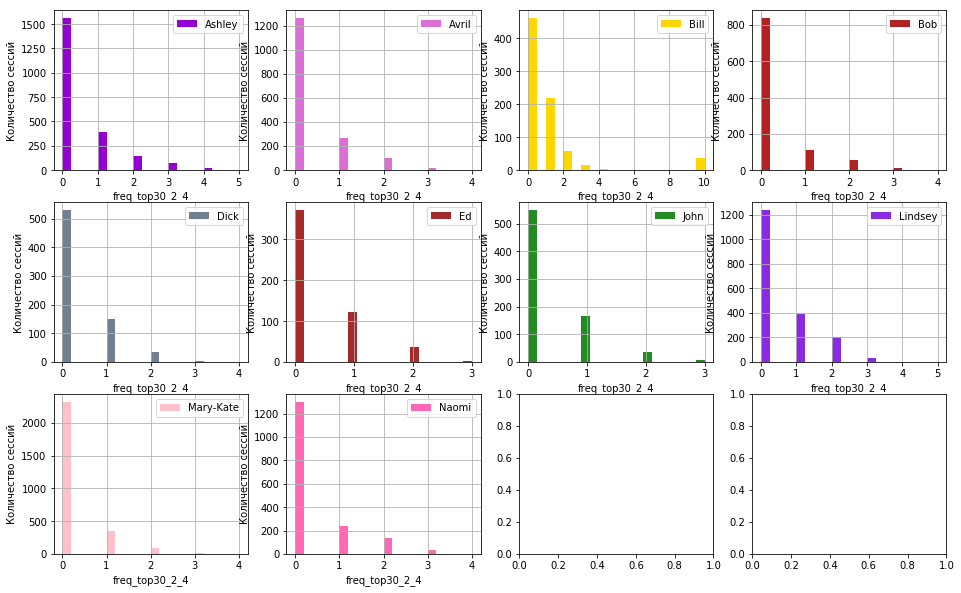

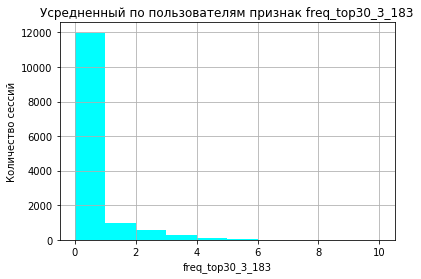

Распределение признака freq_top30_3_183 для каждого пользователя


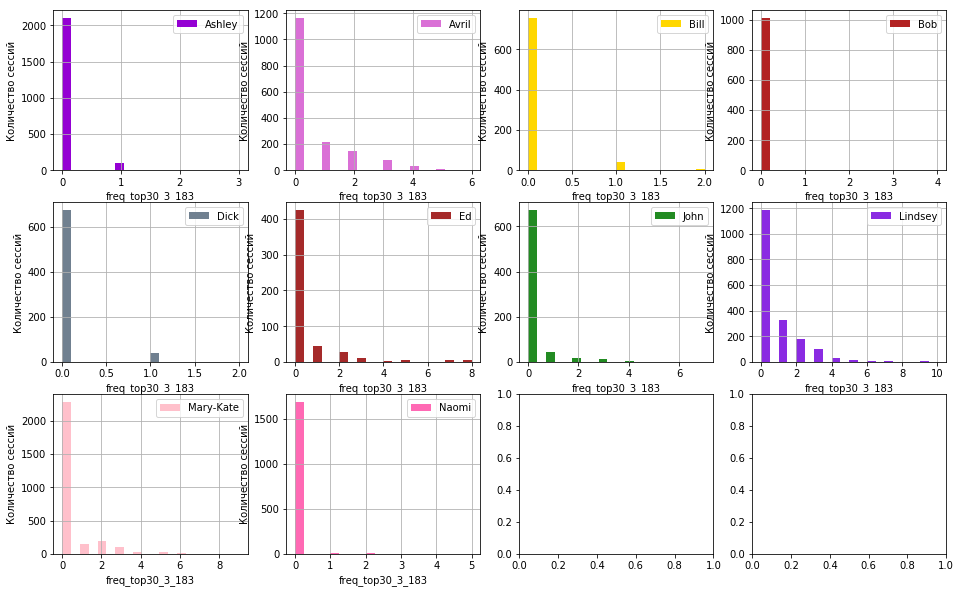

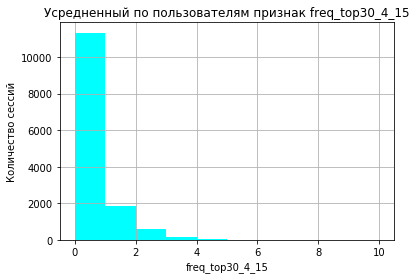

Распределение признака freq_top30_4_15 для каждого пользователя


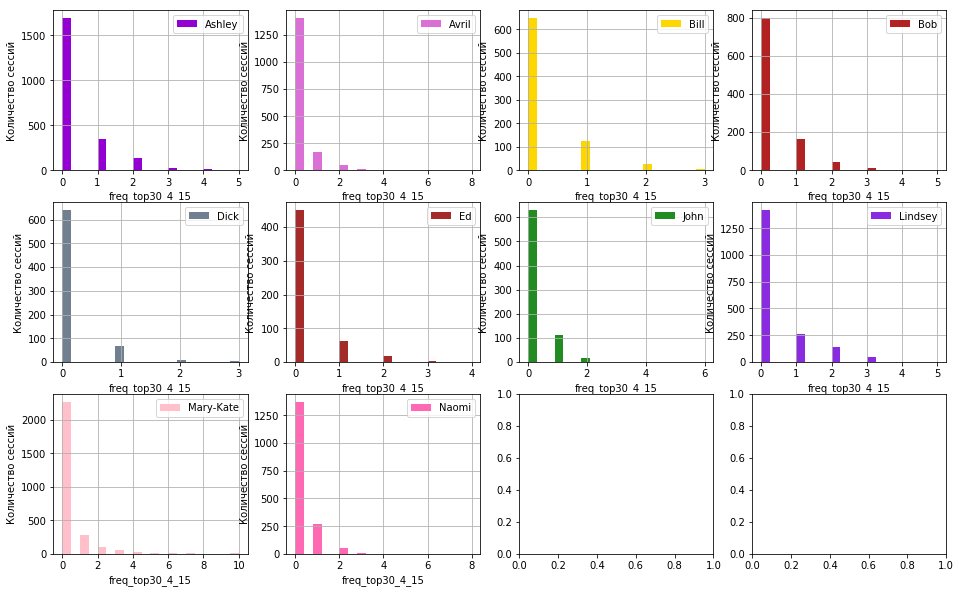

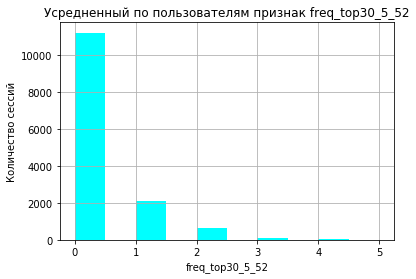

Распределение признака freq_top30_5_52 для каждого пользователя


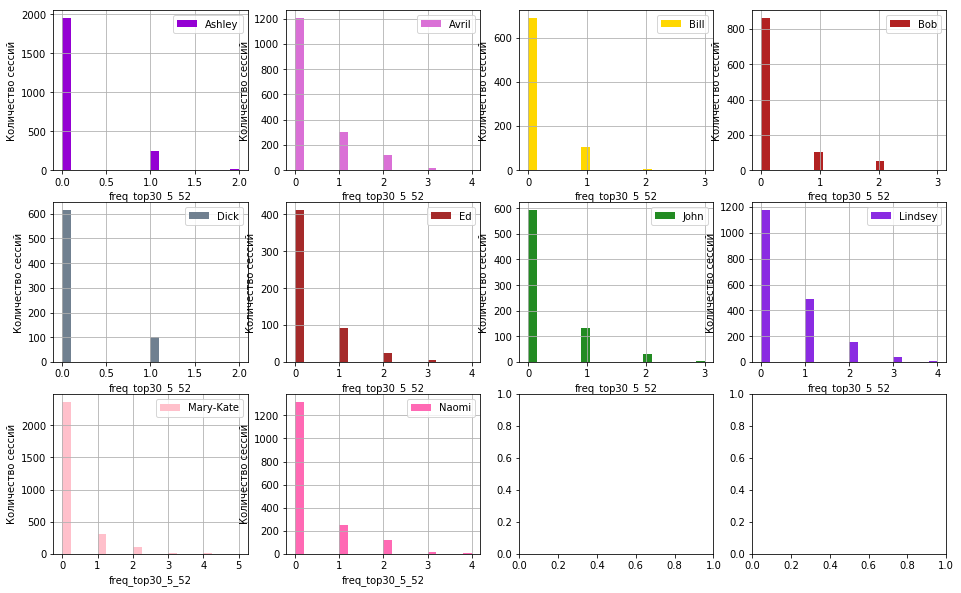

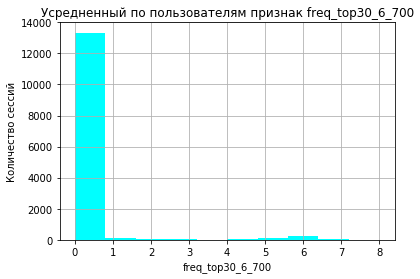

Распределение признака freq_top30_6_700 для каждого пользователя


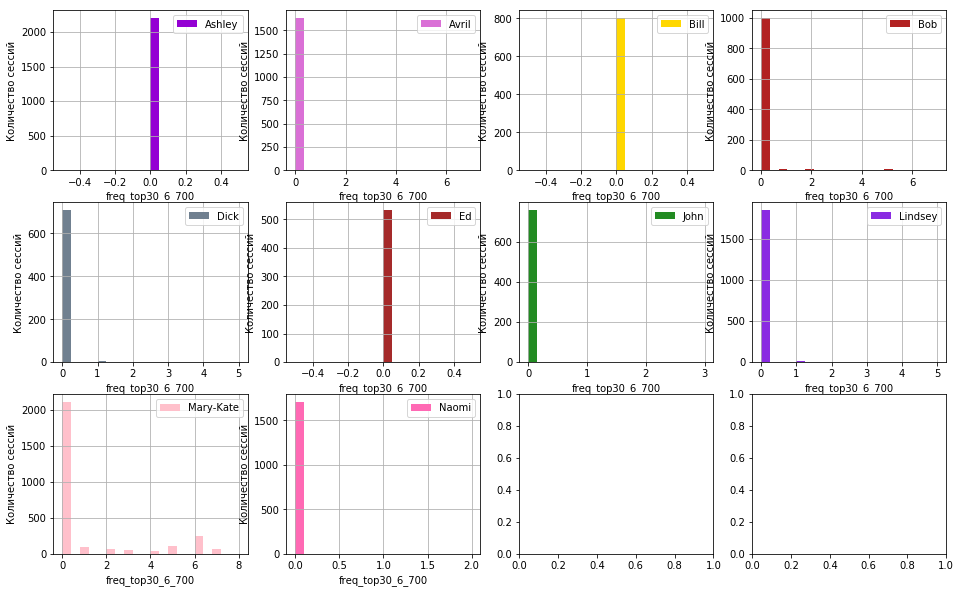

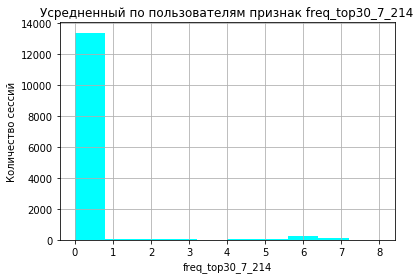

Распределение признака freq_top30_7_214 для каждого пользователя


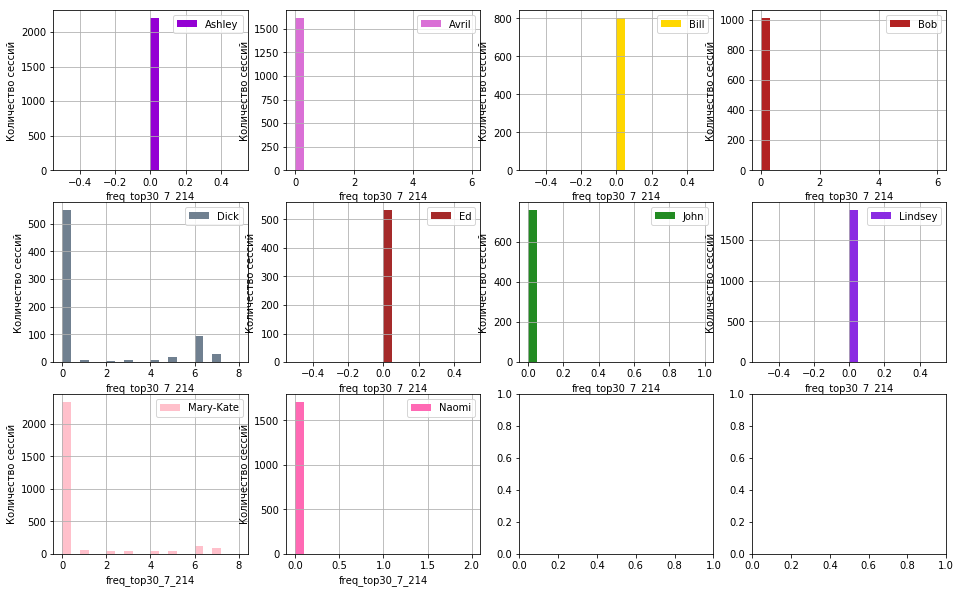

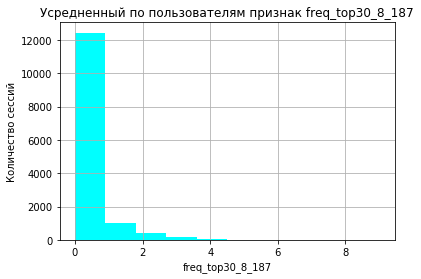

Распределение признака freq_top30_8_187 для каждого пользователя


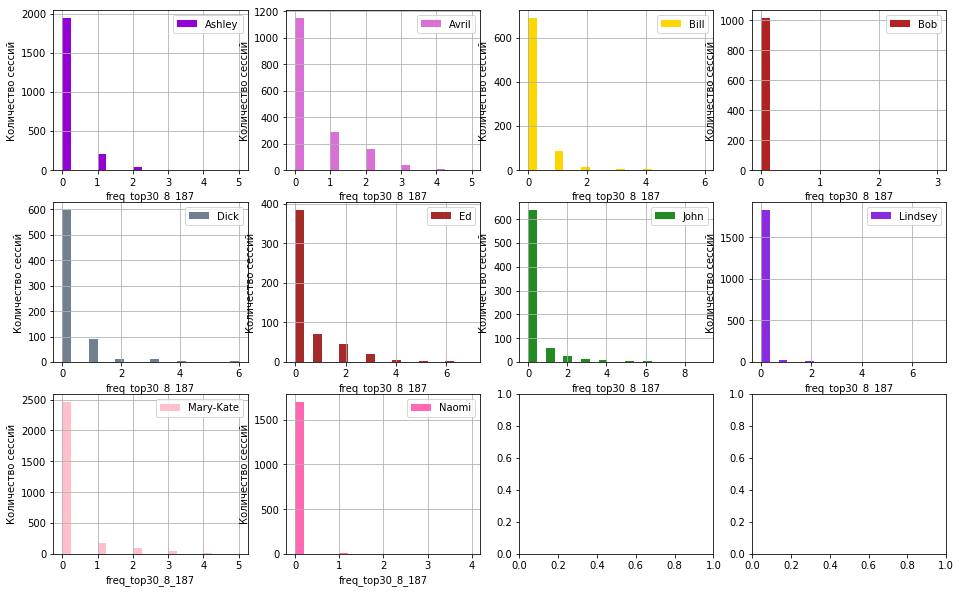

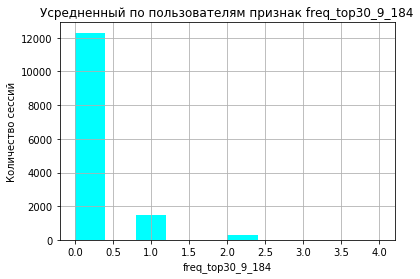

Распределение признака freq_top30_9_184 для каждого пользователя


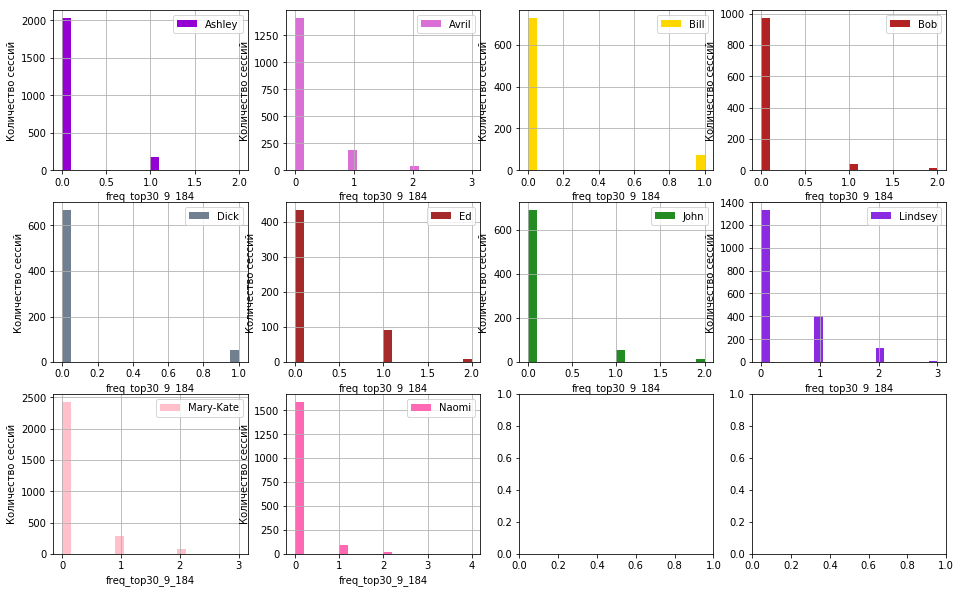

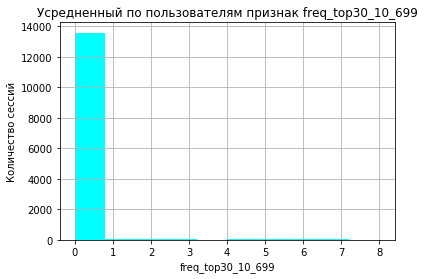

Распределение признака freq_top30_10_699 для каждого пользователя


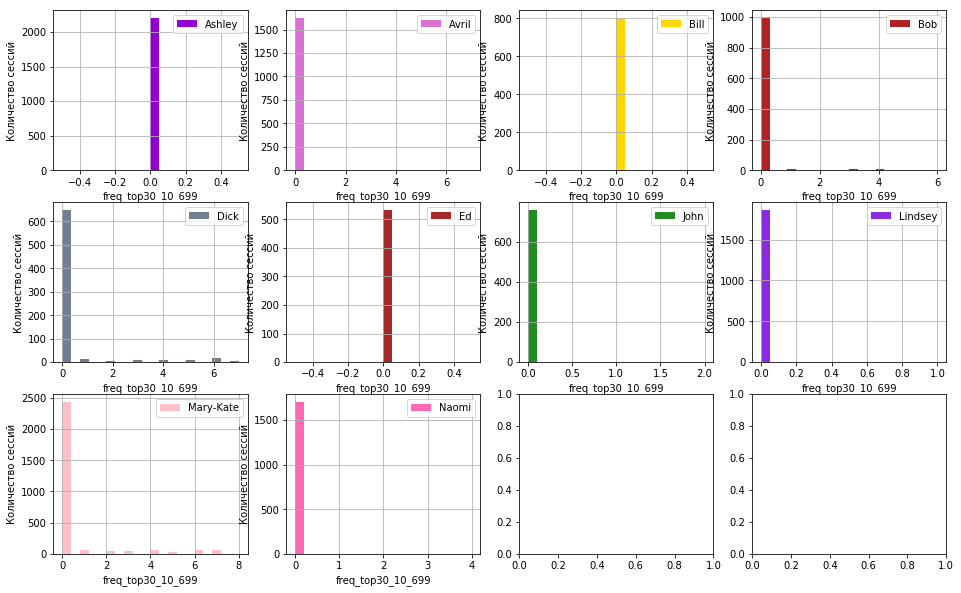

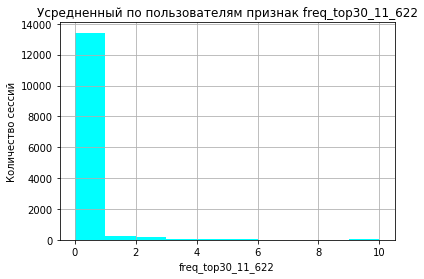

Распределение признака freq_top30_11_622 для каждого пользователя


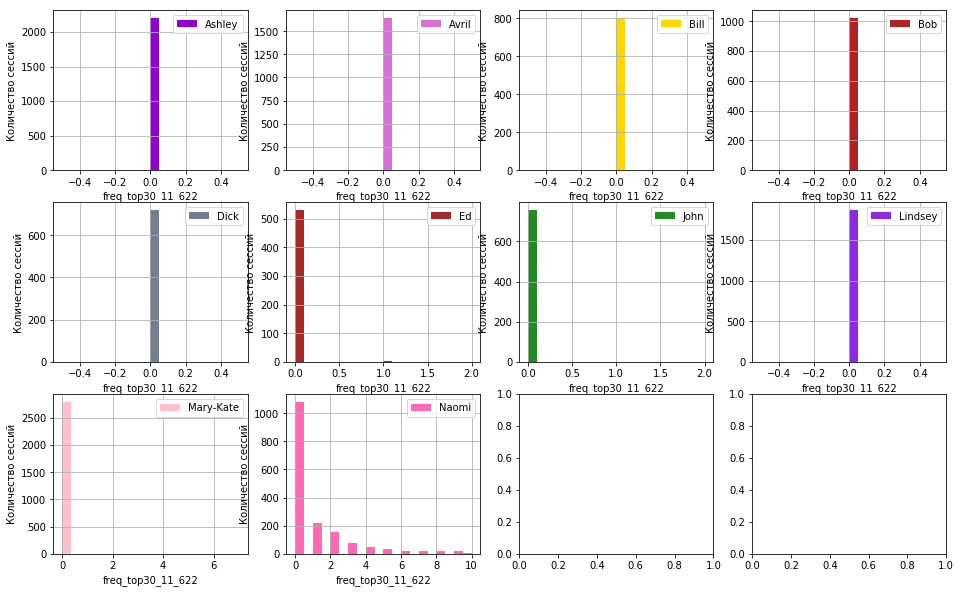

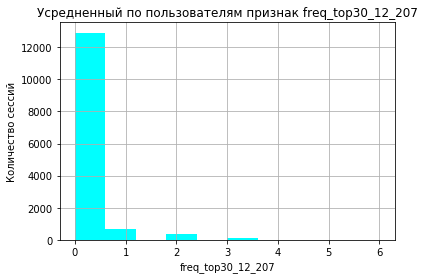

Распределение признака freq_top30_12_207 для каждого пользователя


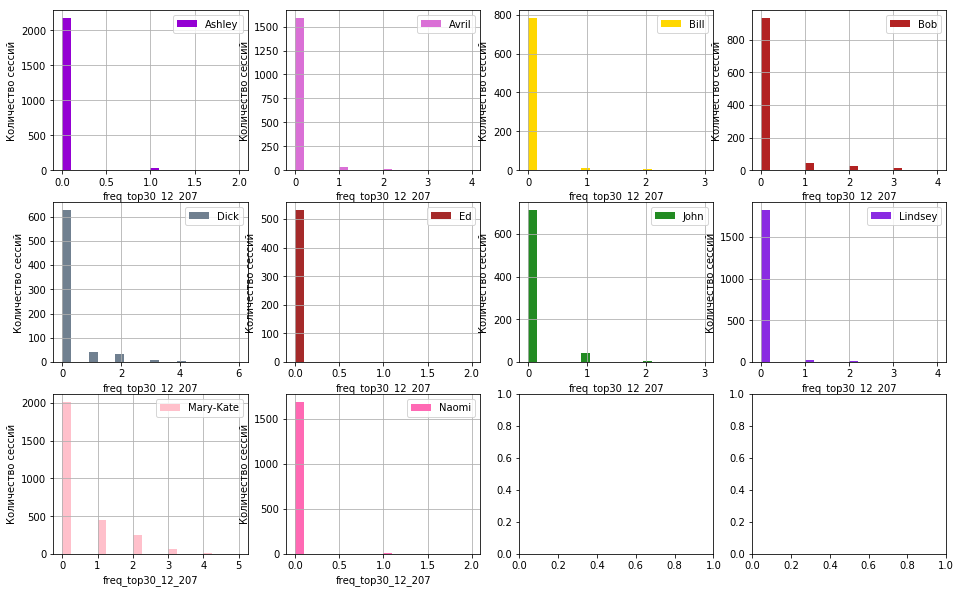

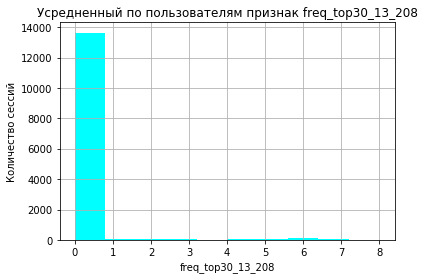

Распределение признака freq_top30_13_208 для каждого пользователя


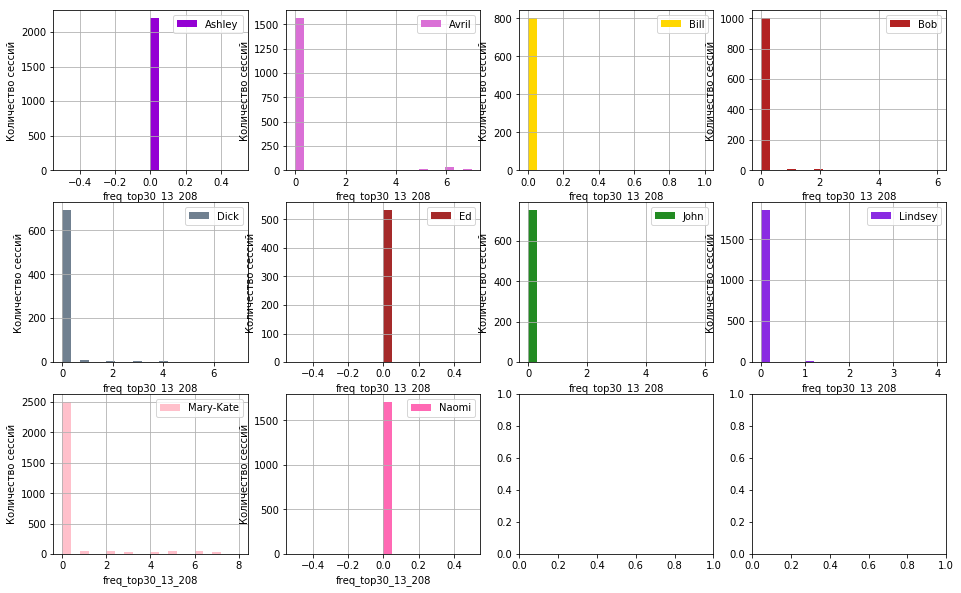

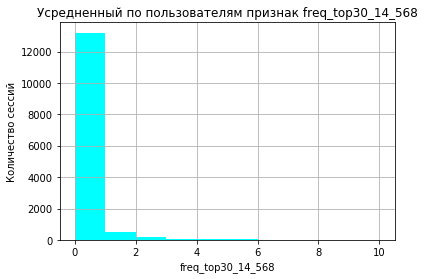

Распределение признака freq_top30_14_568 для каждого пользователя


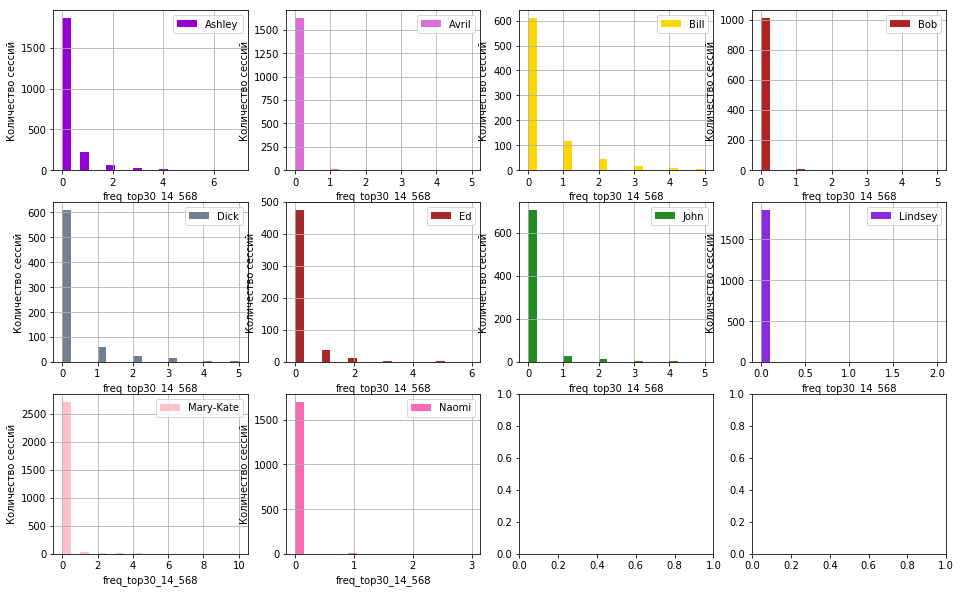

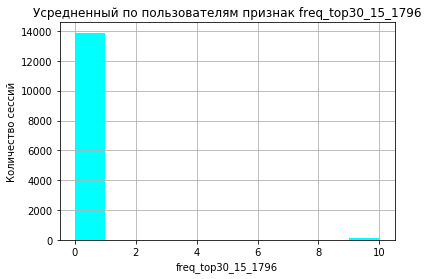

Распределение признака freq_top30_15_1796 для каждого пользователя


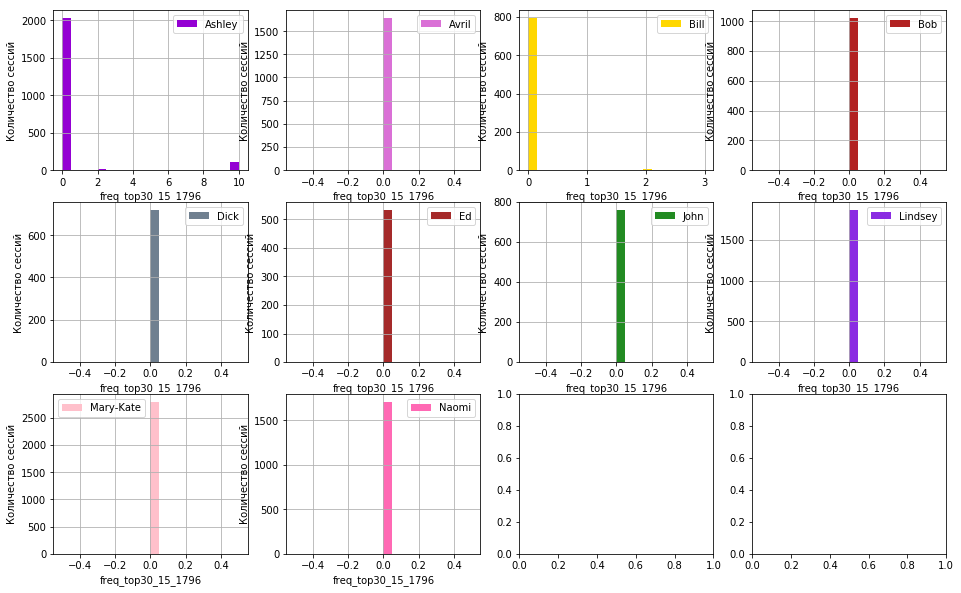

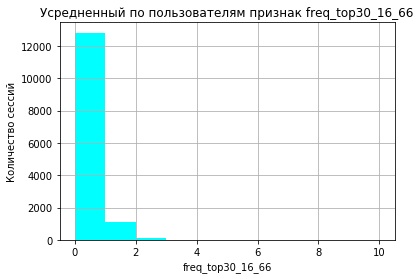

Распределение признака freq_top30_16_66 для каждого пользователя


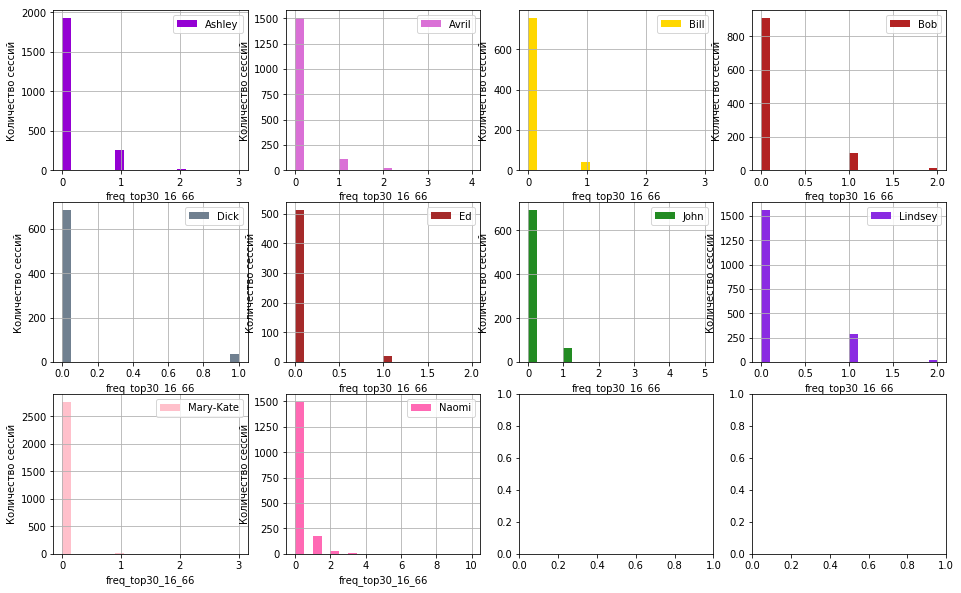

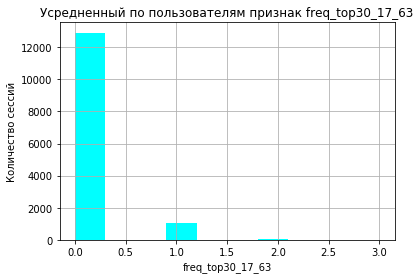

Распределение признака freq_top30_17_63 для каждого пользователя


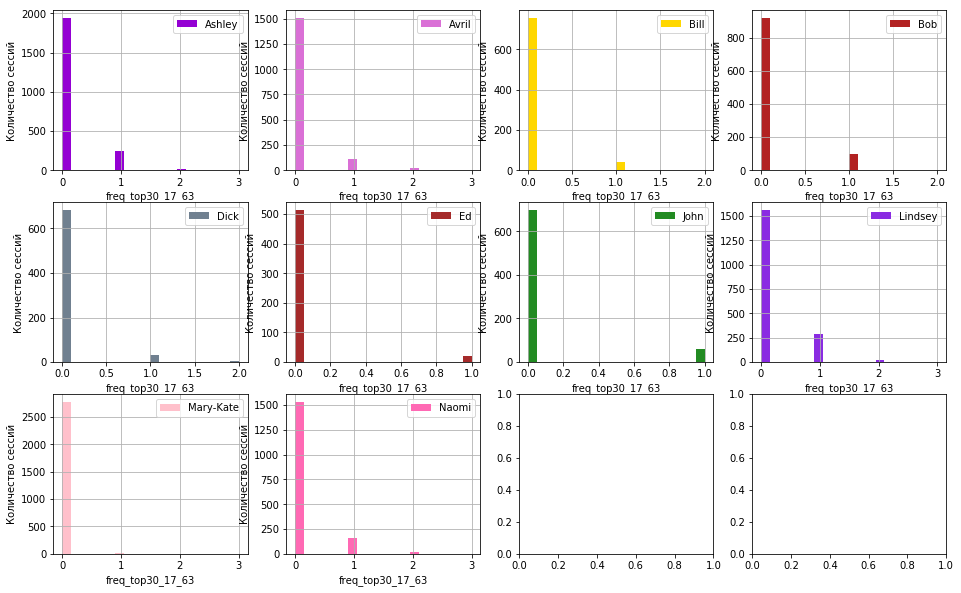

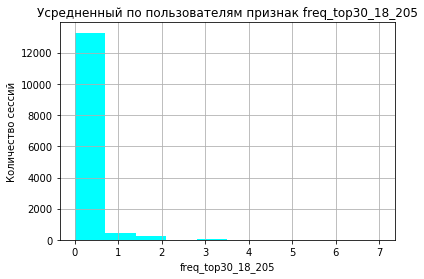

Распределение признака freq_top30_18_205 для каждого пользователя


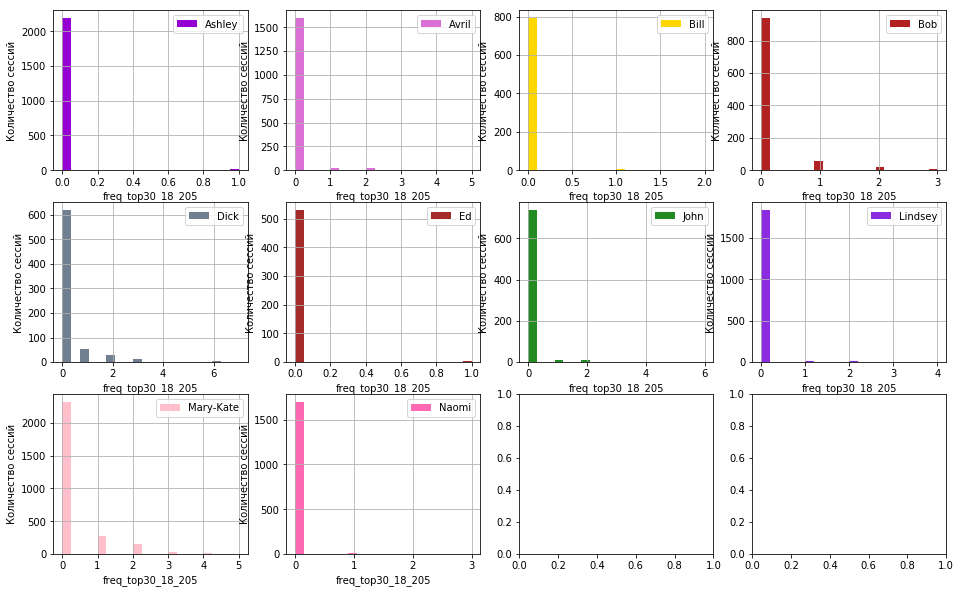

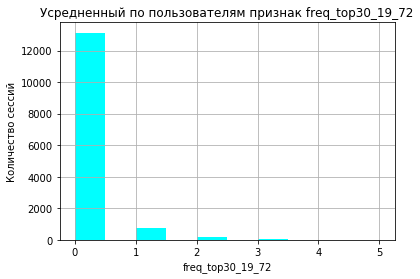

Распределение признака freq_top30_19_72 для каждого пользователя


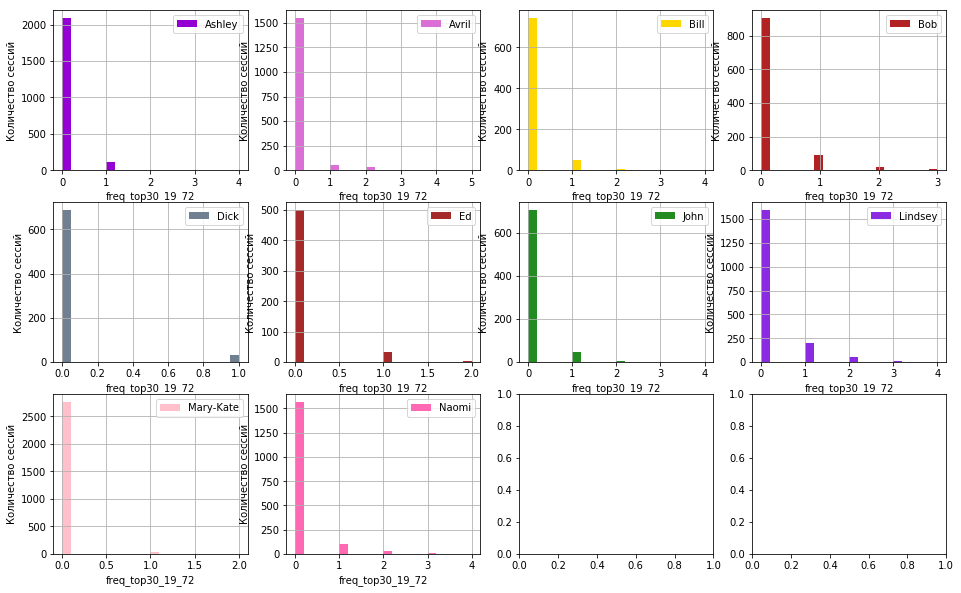

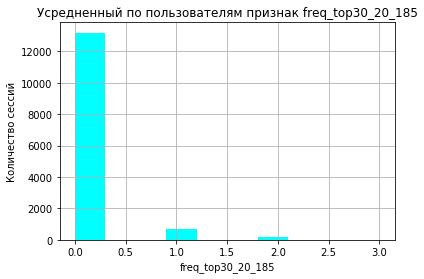

Распределение признака freq_top30_20_185 для каждого пользователя


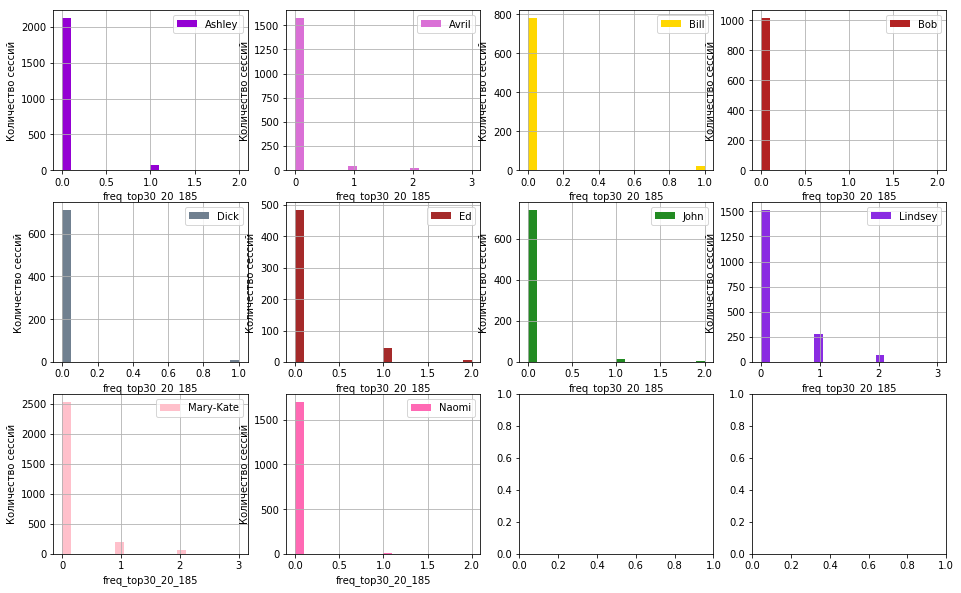

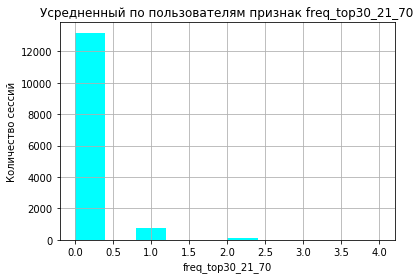

Распределение признака freq_top30_21_70 для каждого пользователя


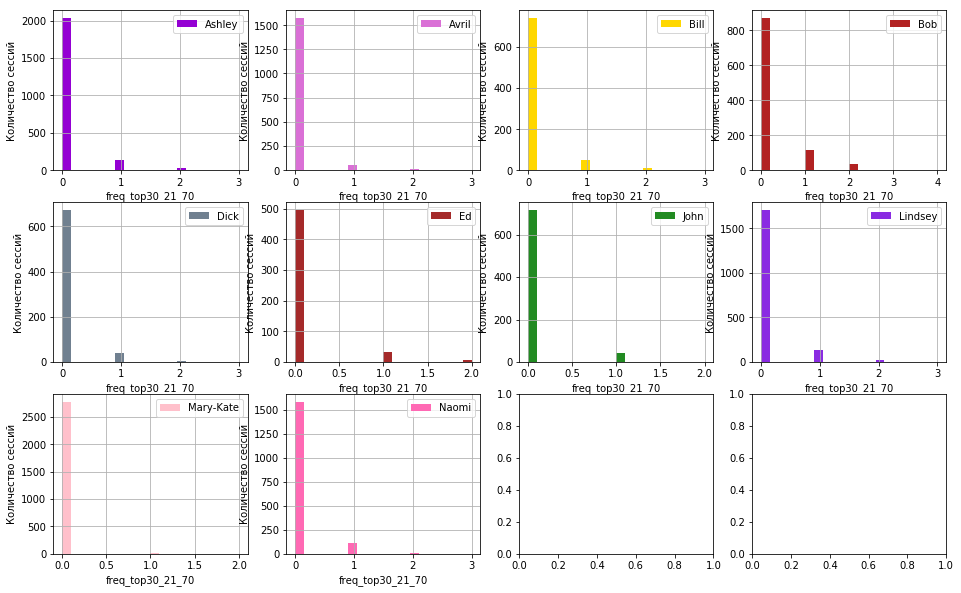

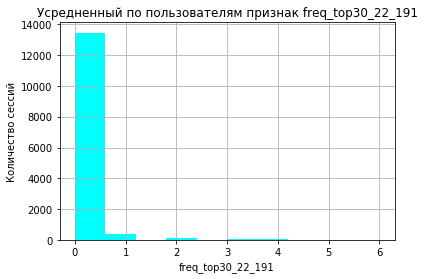

Распределение признака freq_top30_22_191 для каждого пользователя


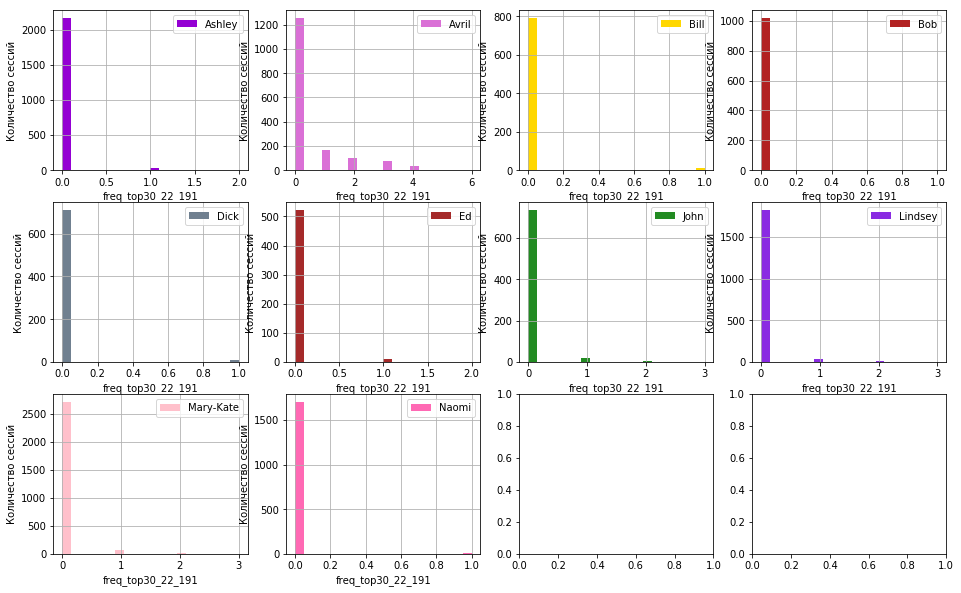

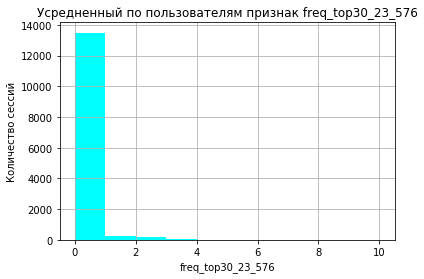

Распределение признака freq_top30_23_576 для каждого пользователя


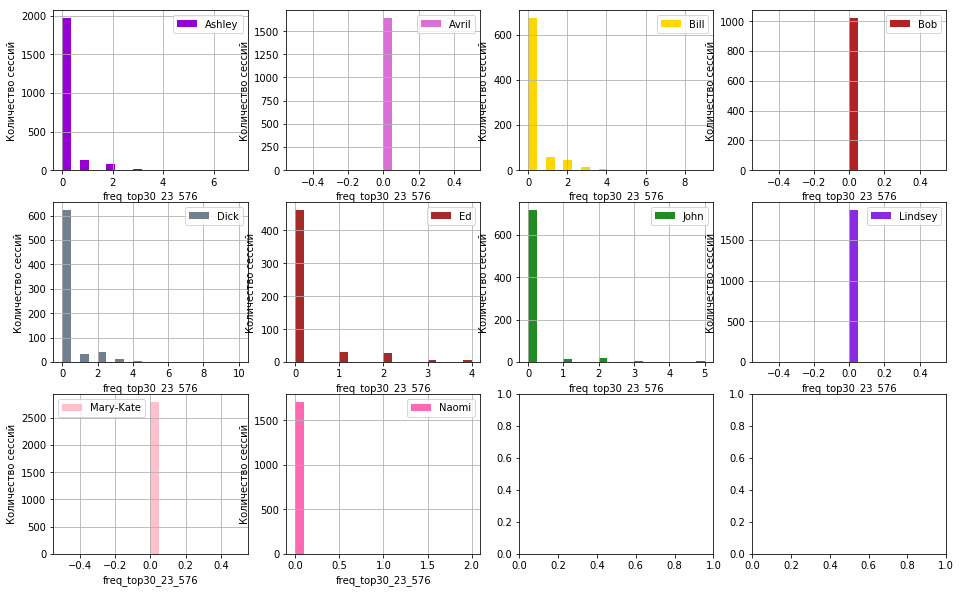

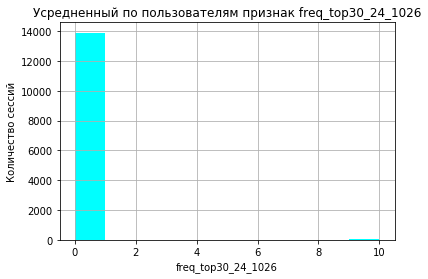

Распределение признака freq_top30_24_1026 для каждого пользователя


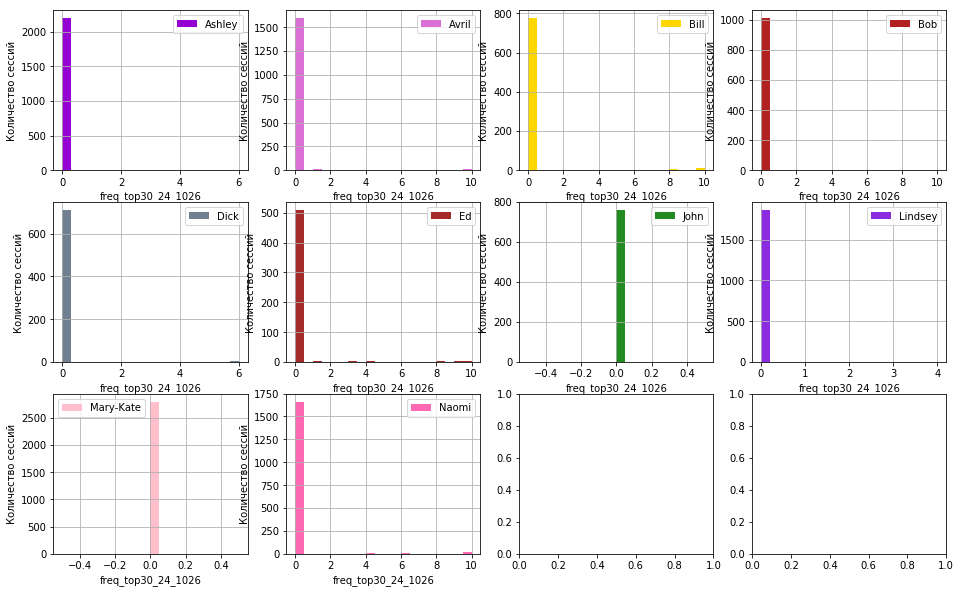

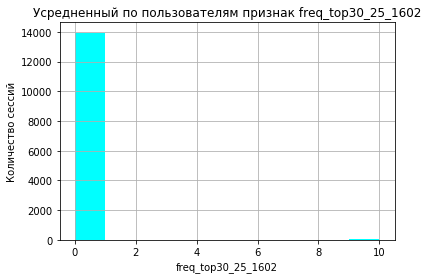

Распределение признака freq_top30_25_1602 для каждого пользователя


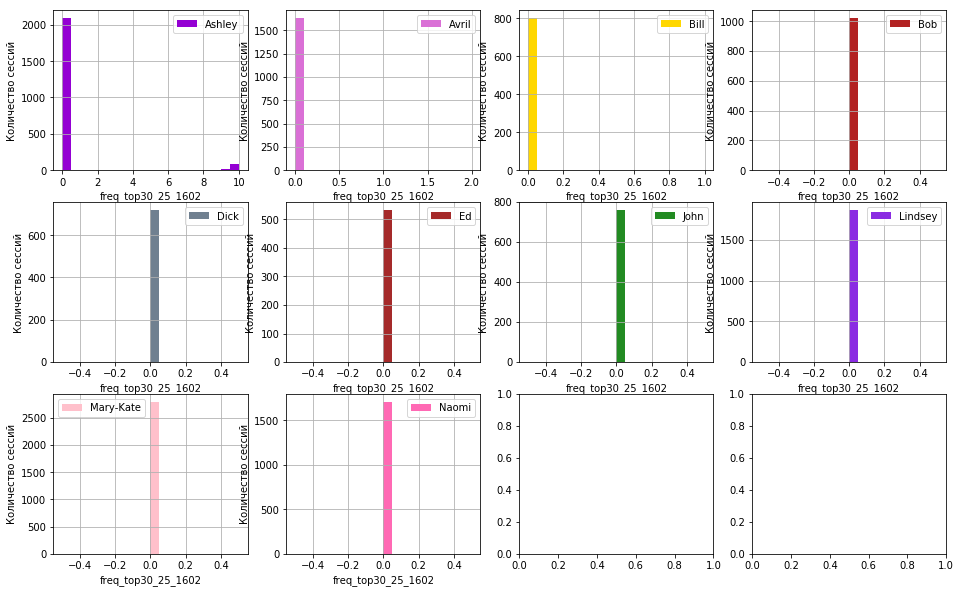

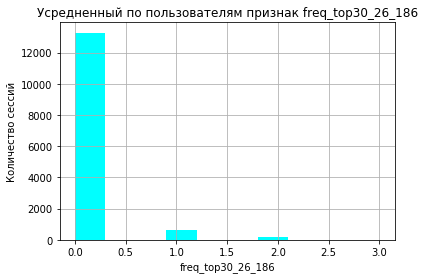

Распределение признака freq_top30_26_186 для каждого пользователя


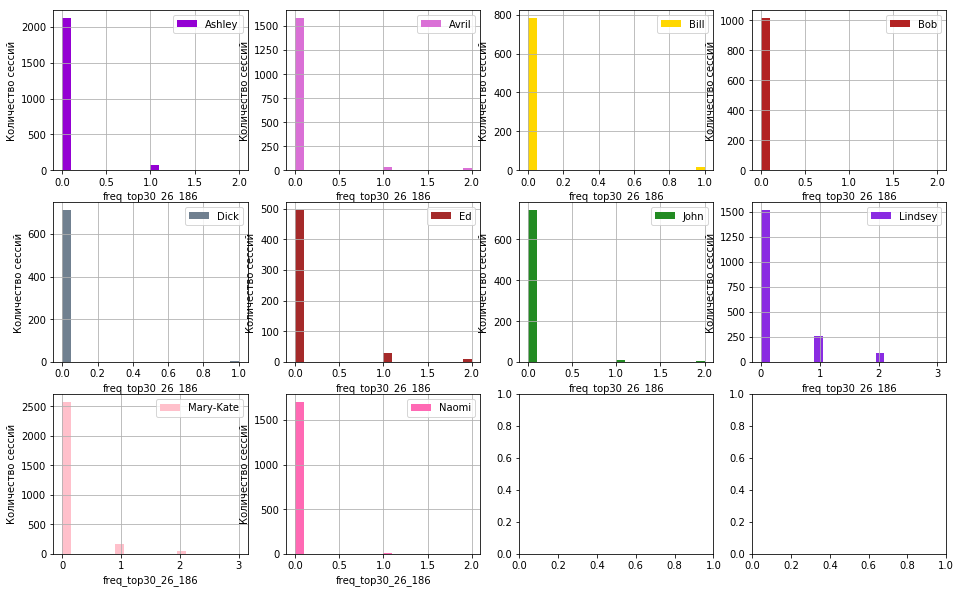

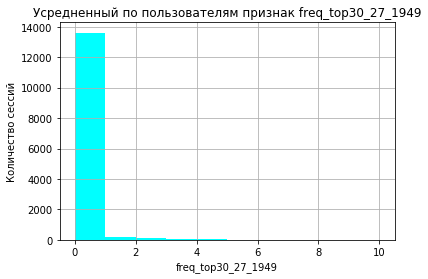

Распределение признака freq_top30_27_1949 для каждого пользователя


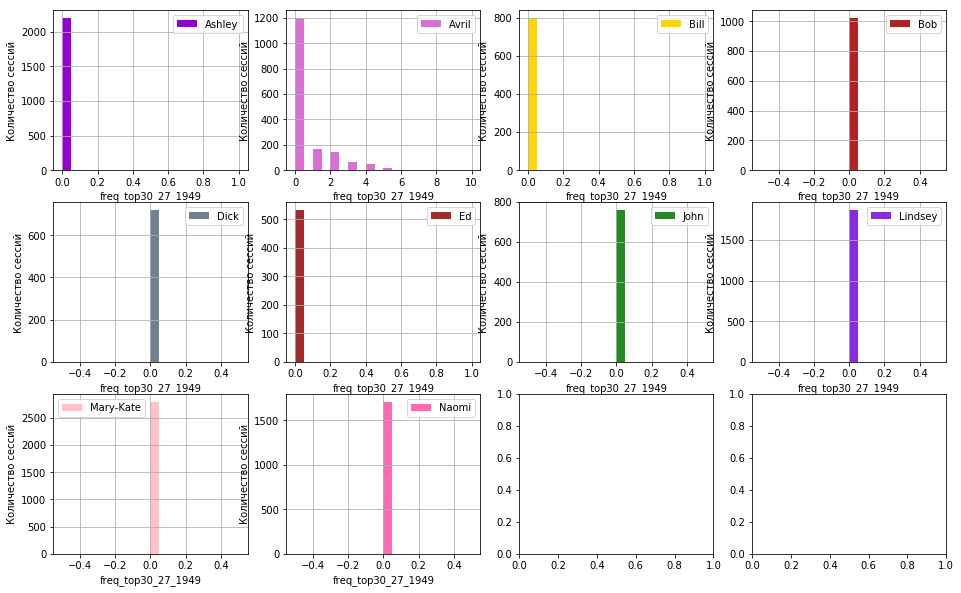

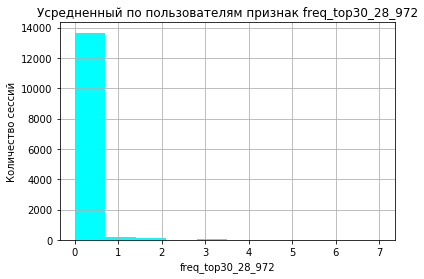

Распределение признака freq_top30_28_972 для каждого пользователя


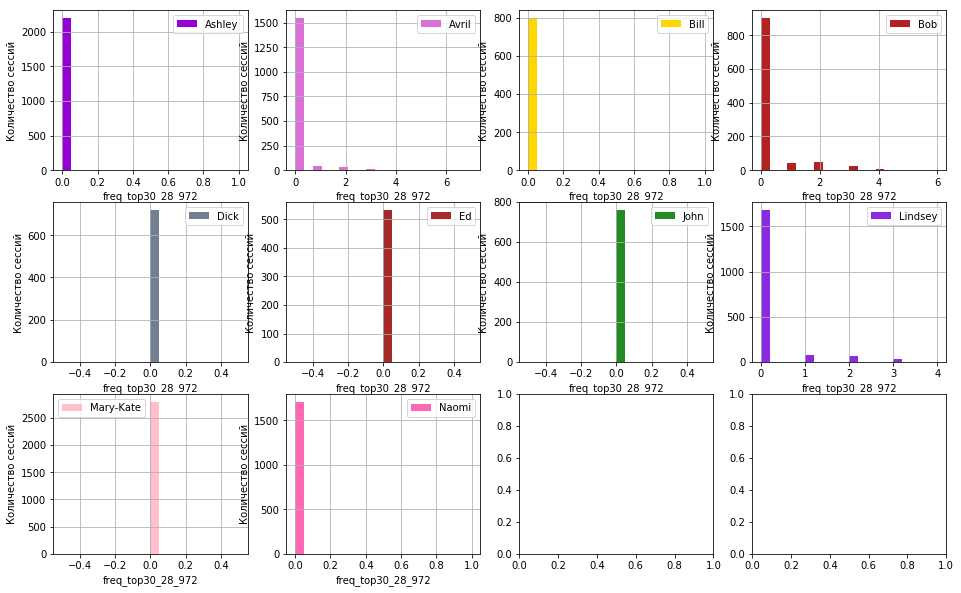

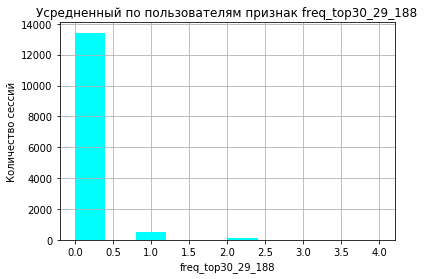

Распределение признака freq_top30_29_188 для каждого пользователя


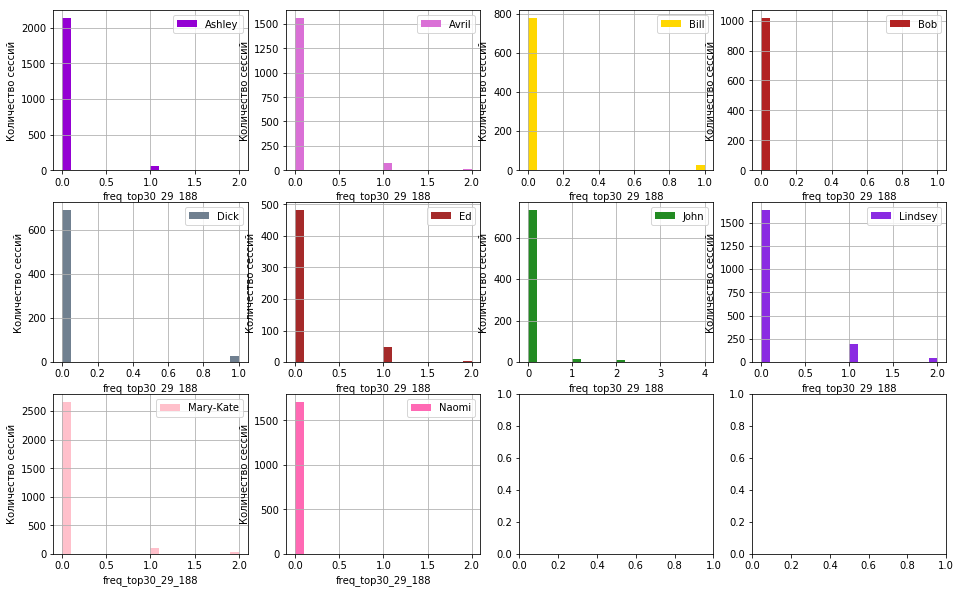

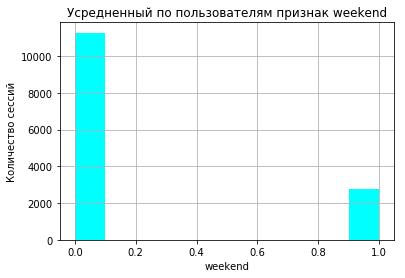

Распределение признака weekend для каждого пользователя


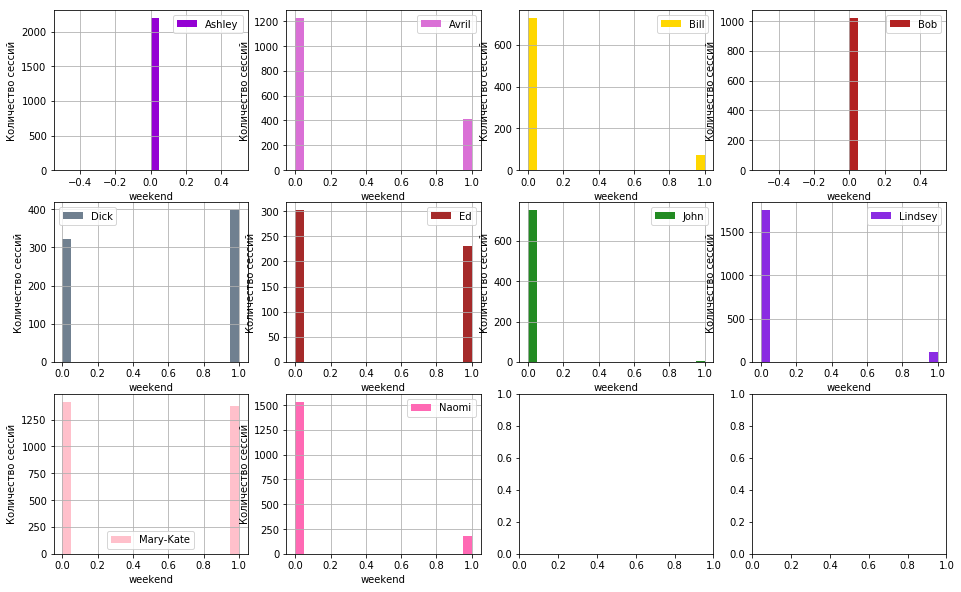

In [39]:
for feature in new_features_10users.columns[:-2]:
    new_features_10users[feature].hist(color='aqua', bins=10)
    plt.title('Усредненный по пользователям признак ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Количество сессий')
    plt.show()

    print('Распределение признака ' + feature + ' для каждого пользователя')

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

    # как вариант, можно и по-другому
    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
        col = feature
        sub_df[col].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=20)
#                                    bins=(sub_df[col].max() - sub_df[col].min() + 1))
        axes[idx // 4, idx % 4].legend()
    #     axes[idx // 4, idx % 4].set_xlim([1, 10])
        axes[idx // 4, idx % 4].set_xlabel(feature)
        axes[idx // 4, idx % 4].set_ylabel('Количество сессий')

    plt.show()

In [40]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
new_features_10users_s10_w7['user_id'] = new_features_10users_s10_w7['target'].map(id_name_dict)

color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

In [41]:
new_features_10users_s10_w7.columns[:-2]

Index(['start_year', 'start_month', 'start_day', 'time_of_day',
       'mean_site_time', 'freq_top30_0_210', 'freq_top30_1_51',
       'freq_top30_2_4', 'freq_top30_3_183', 'freq_top30_4_15',
       'freq_top30_5_52', 'freq_top30_6_700', 'freq_top30_7_214',
       'freq_top30_8_187', 'freq_top30_9_184', 'freq_top30_10_699',
       'freq_top30_11_622', 'freq_top30_12_207', 'freq_top30_13_208',
       'freq_top30_14_568', 'freq_top30_15_1796', 'freq_top30_16_66',
       'freq_top30_17_63', 'freq_top30_18_205', 'freq_top30_19_72',
       'freq_top30_20_185', 'freq_top30_21_70', 'freq_top30_22_191',
       'freq_top30_23_576', 'freq_top30_24_1026', 'freq_top30_25_1602',
       'freq_top30_26_186', 'freq_top30_27_1949', 'freq_top30_28_972',
       'freq_top30_29_188', 'weekend'],
      dtype='object')

In [42]:
new_features_10users_s10_w7['mean_site_time'][new_features_10users_s10_w7['mean_site_time'] > 500000].count()

3

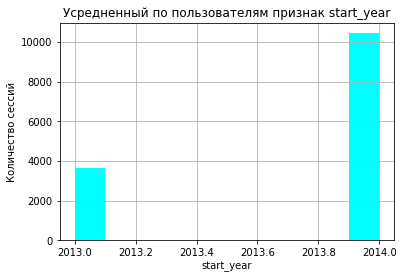

Распределение признака start_year для каждого пользователя


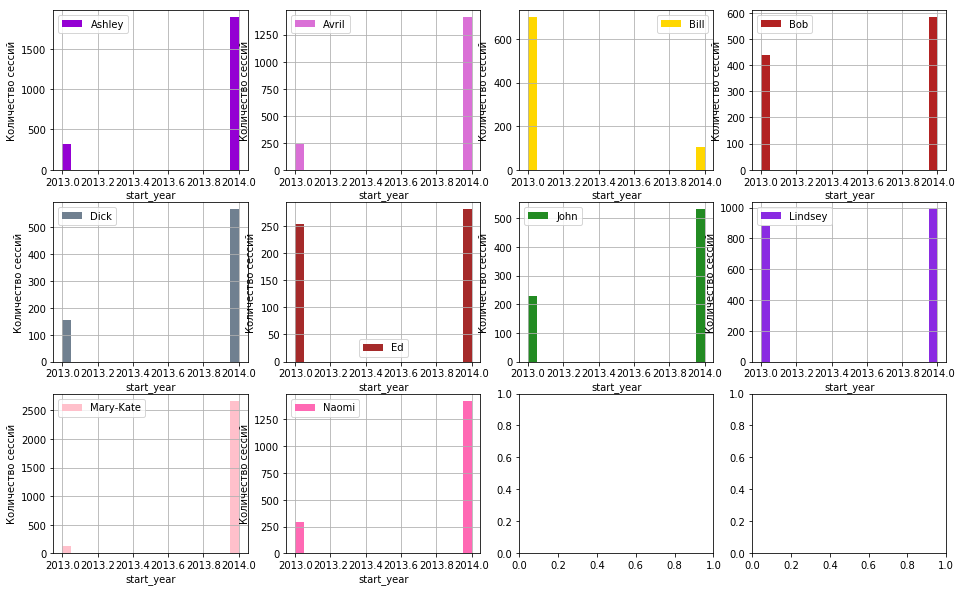

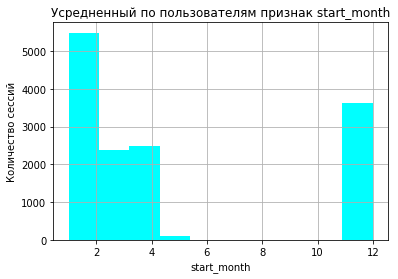

Распределение признака start_month для каждого пользователя


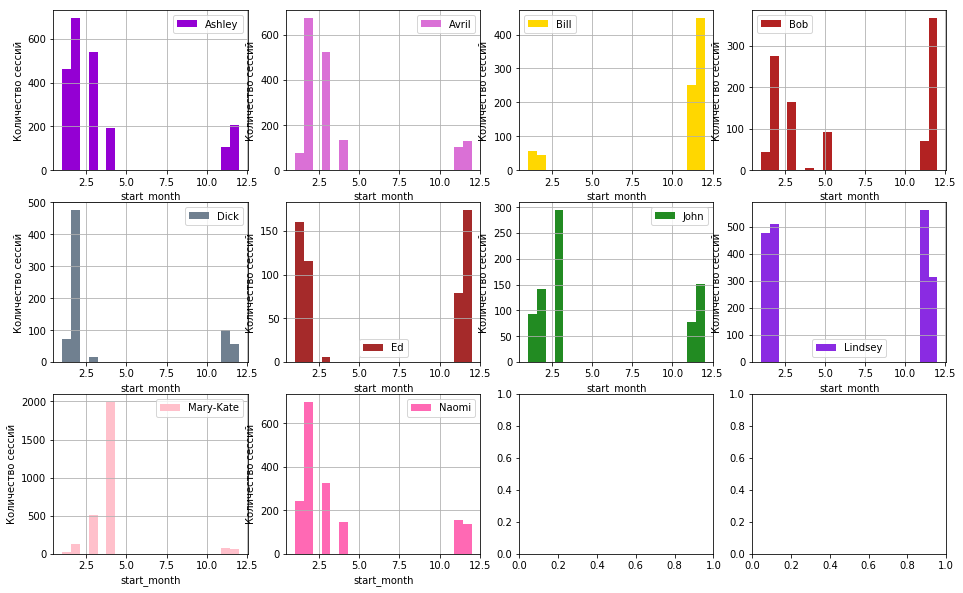

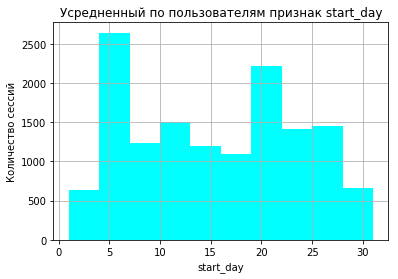

Распределение признака start_day для каждого пользователя


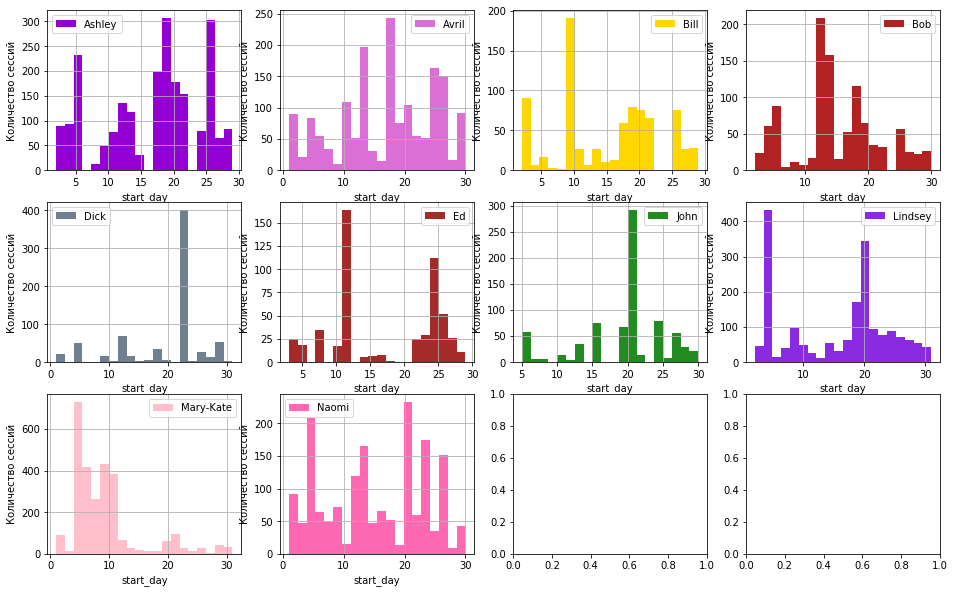

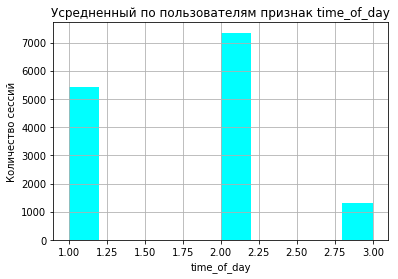

Распределение признака time_of_day для каждого пользователя


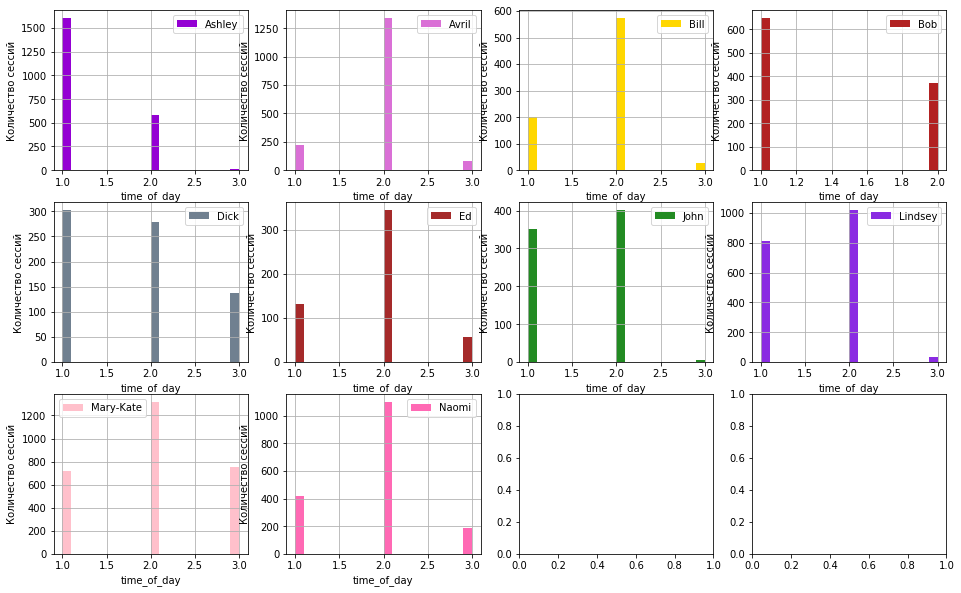

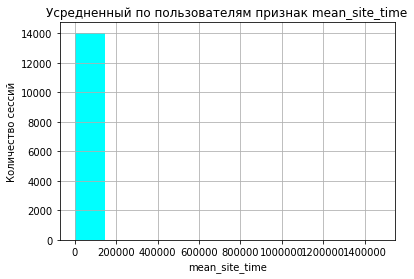

Распределение признака mean_site_time для каждого пользователя


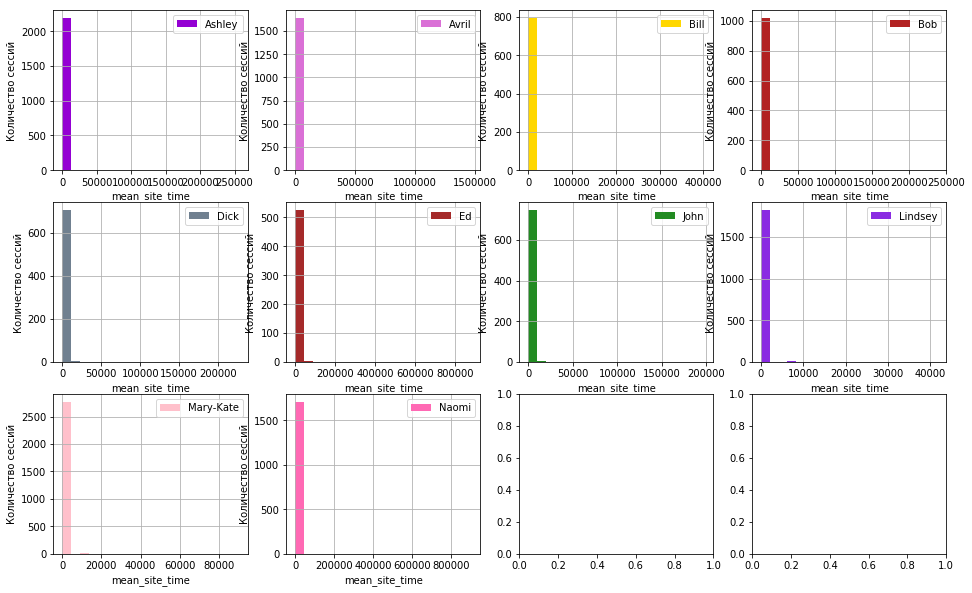

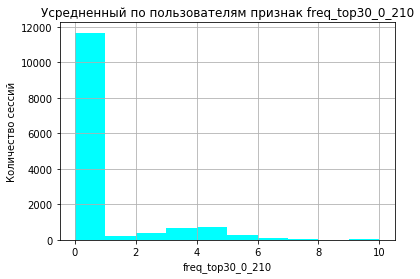

Распределение признака freq_top30_0_210 для каждого пользователя


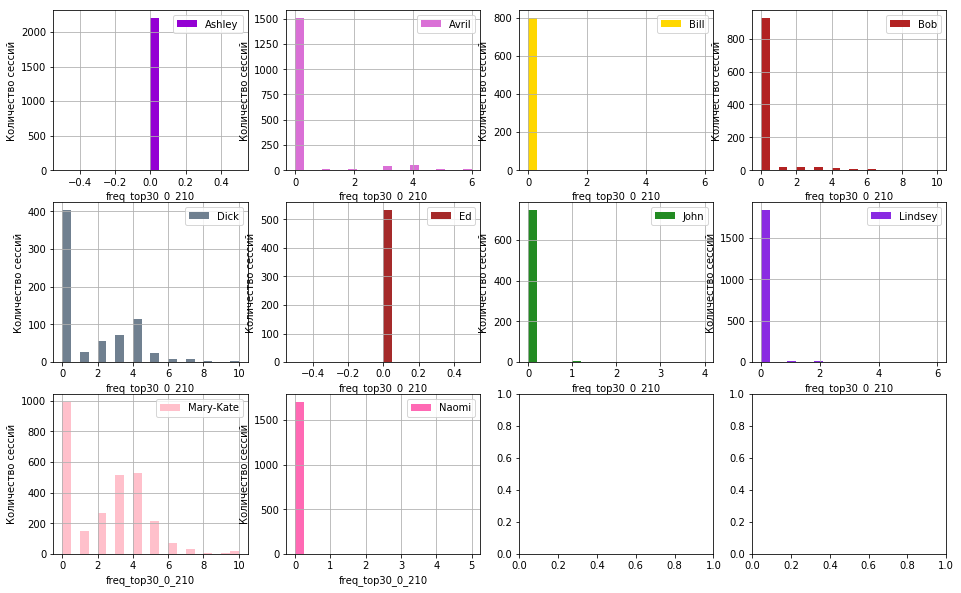

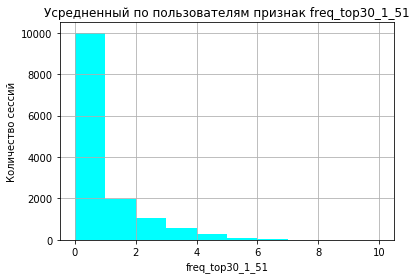

Распределение признака freq_top30_1_51 для каждого пользователя


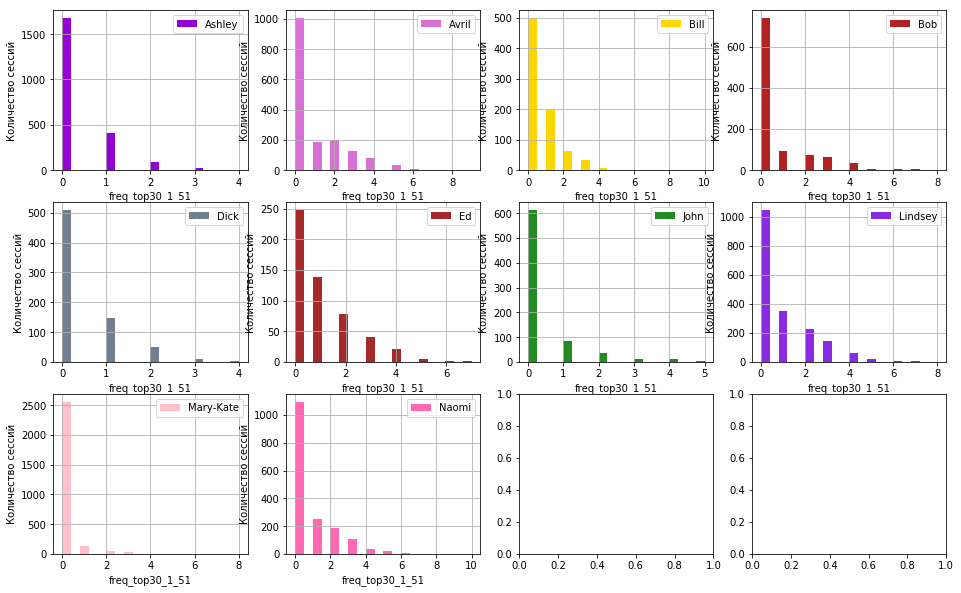

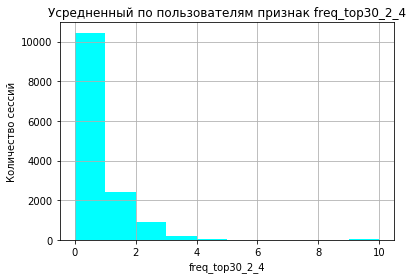

Распределение признака freq_top30_2_4 для каждого пользователя


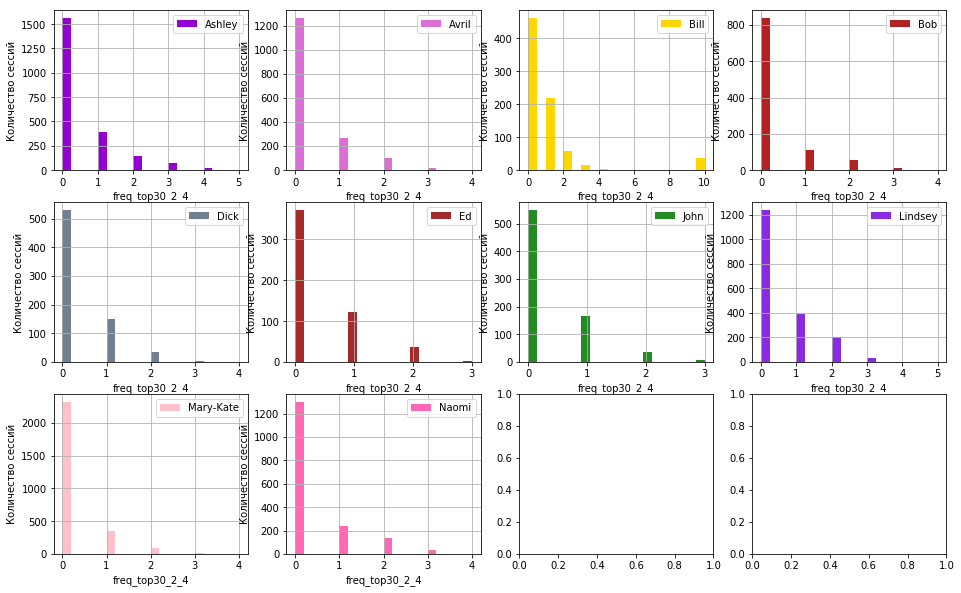

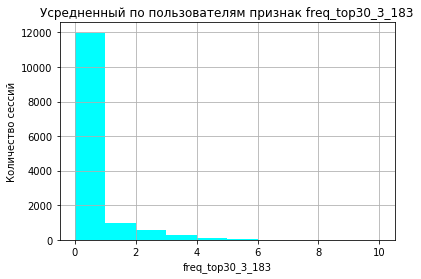

Распределение признака freq_top30_3_183 для каждого пользователя


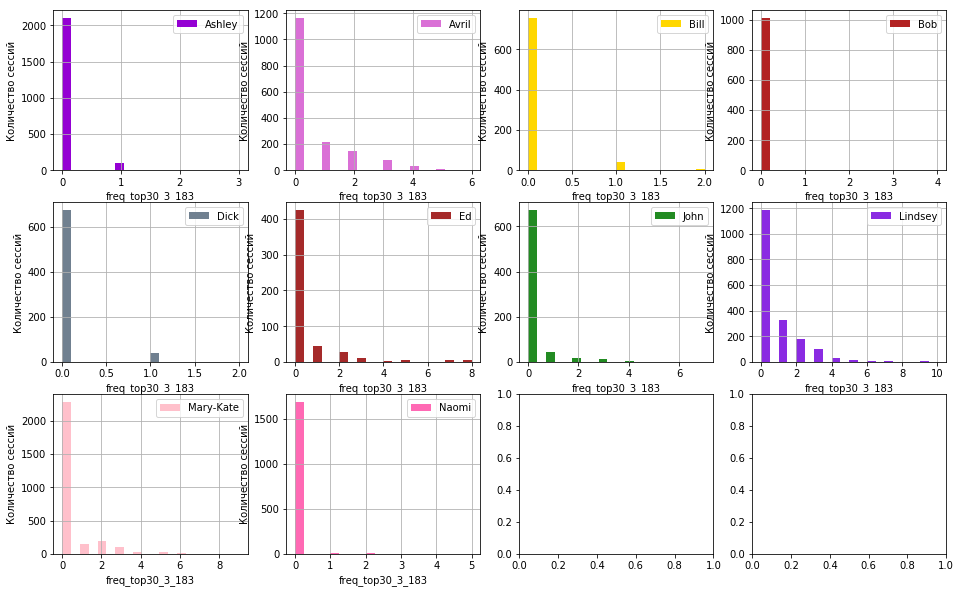

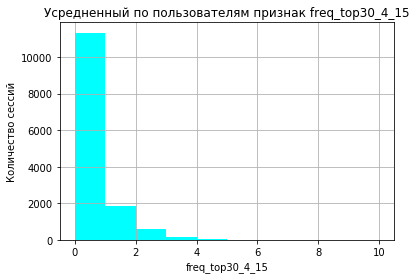

Распределение признака freq_top30_4_15 для каждого пользователя


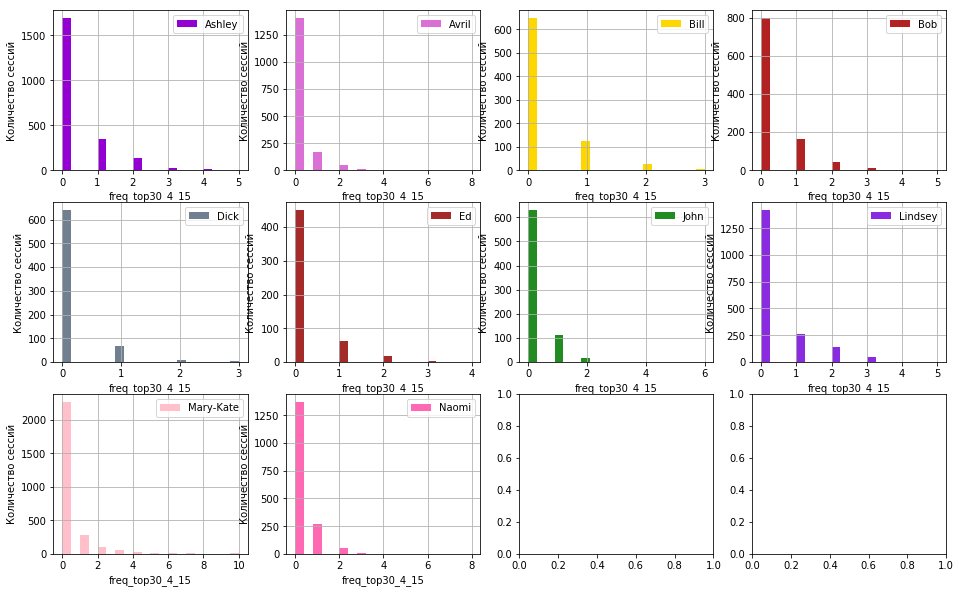

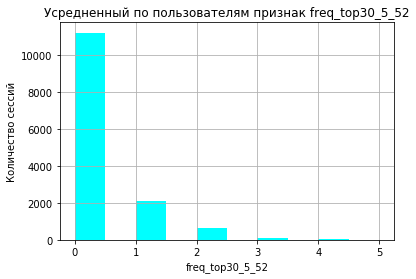

Распределение признака freq_top30_5_52 для каждого пользователя


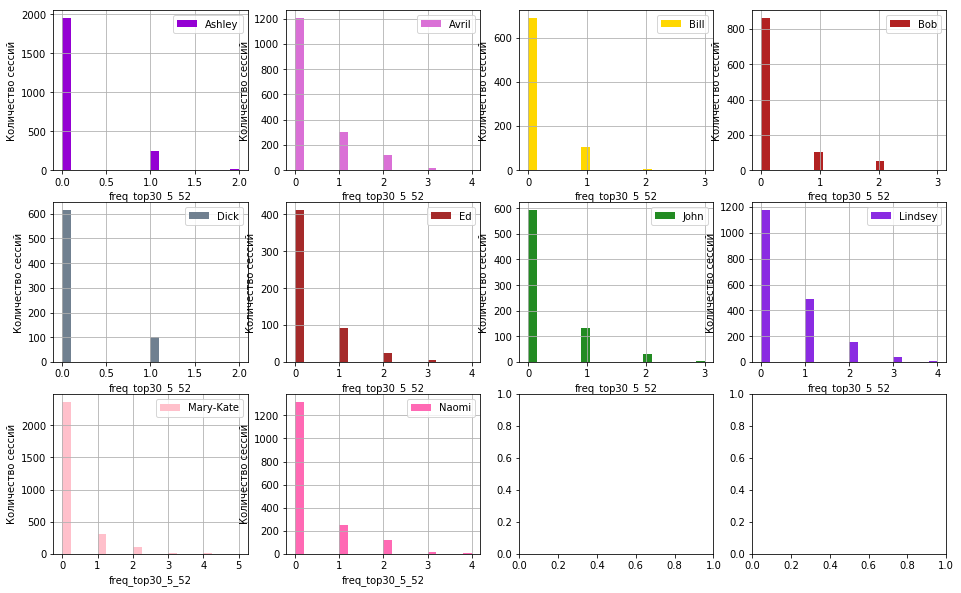

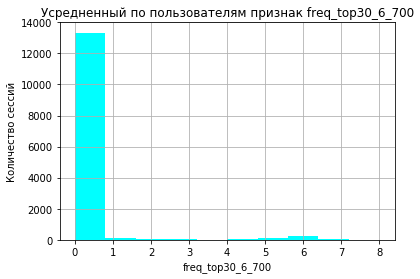

Распределение признака freq_top30_6_700 для каждого пользователя


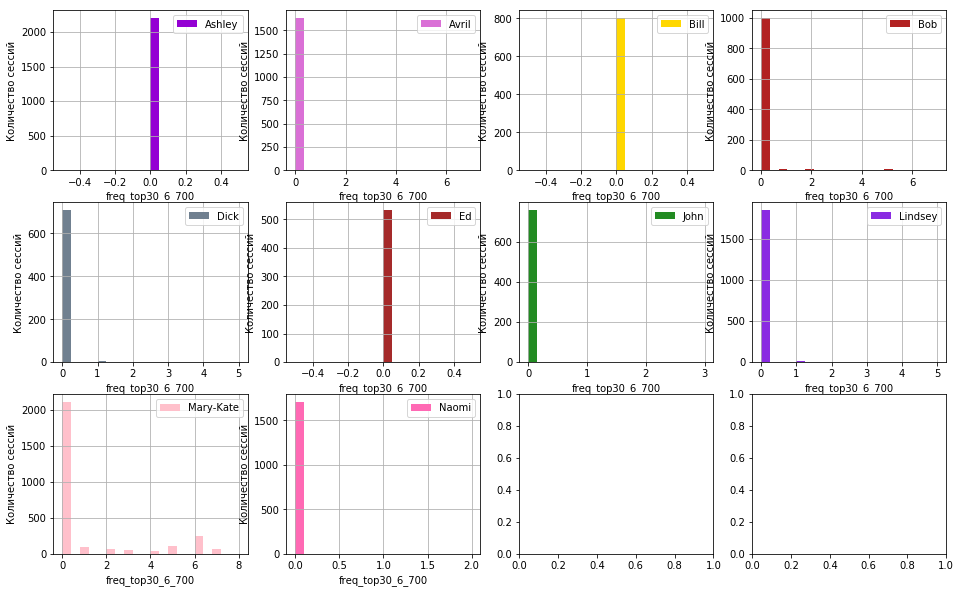

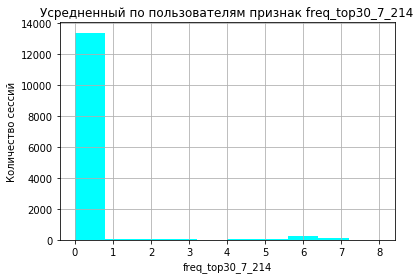

Распределение признака freq_top30_7_214 для каждого пользователя


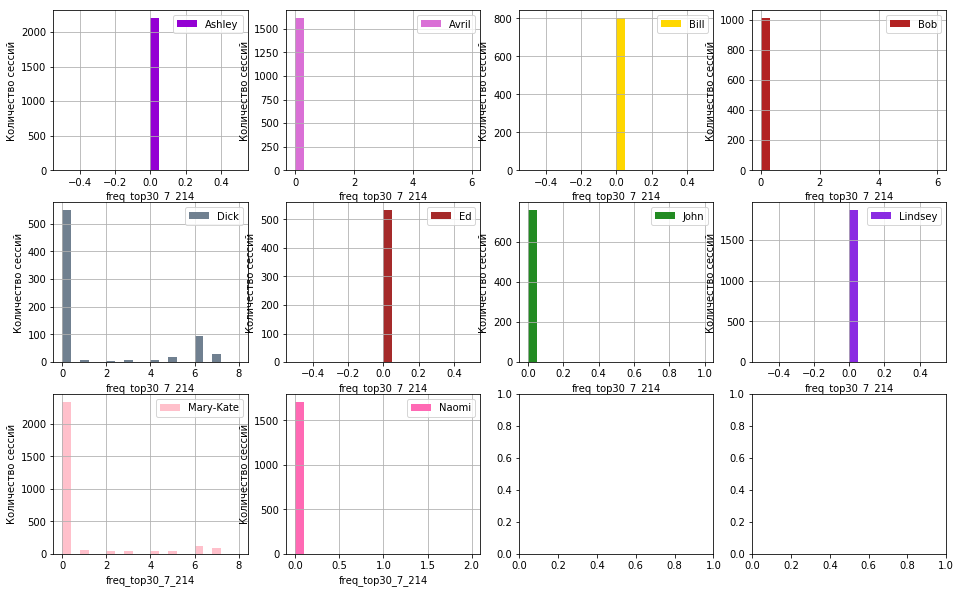

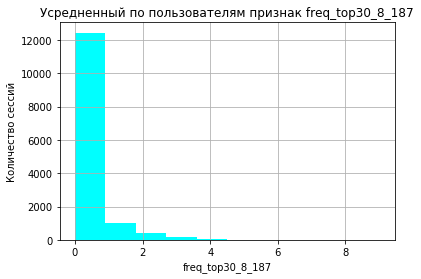

Распределение признака freq_top30_8_187 для каждого пользователя


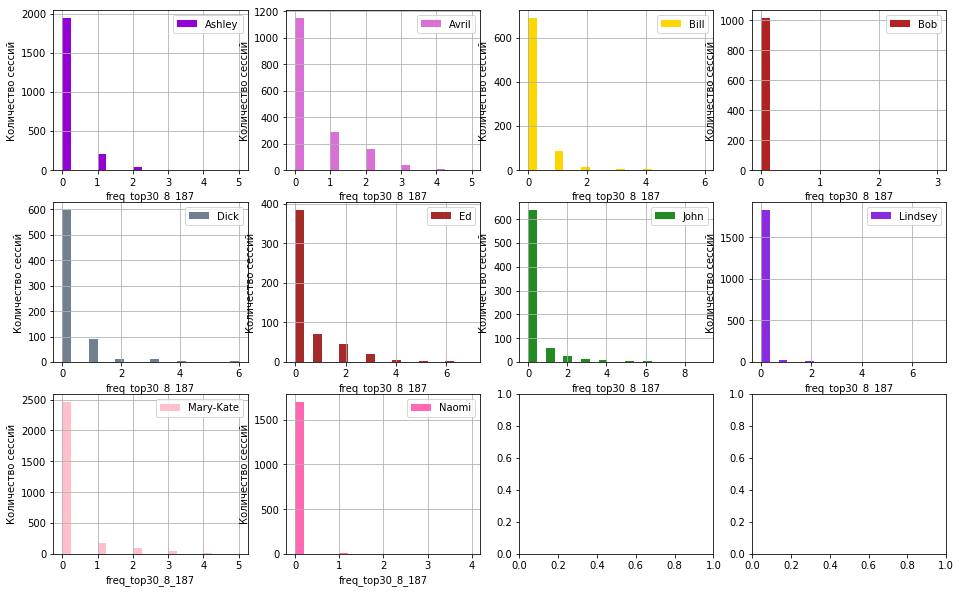

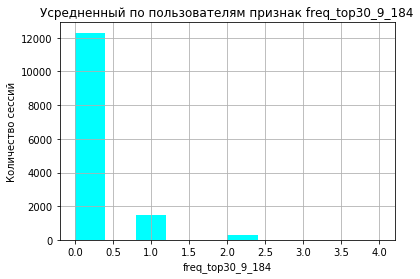

Распределение признака freq_top30_9_184 для каждого пользователя


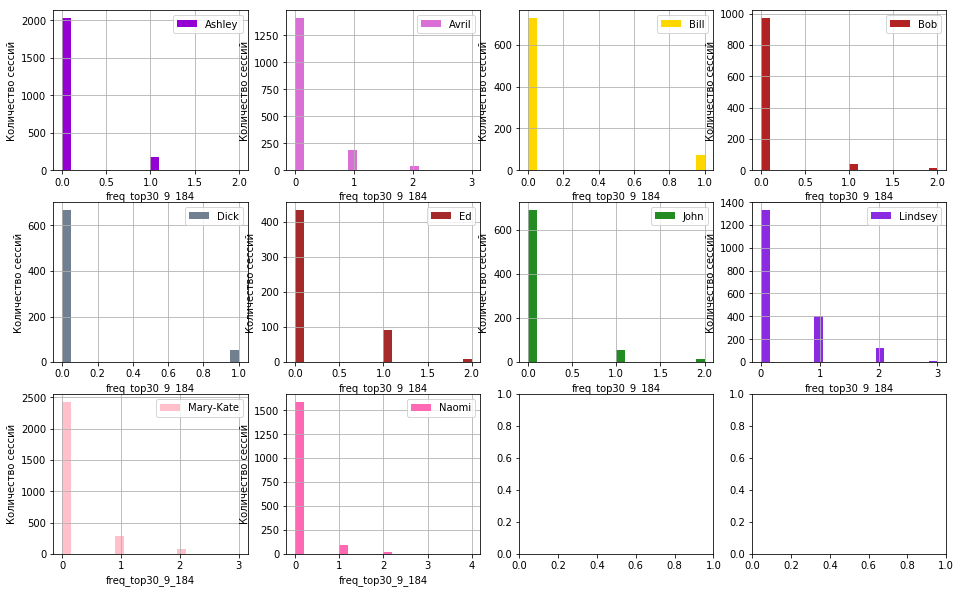

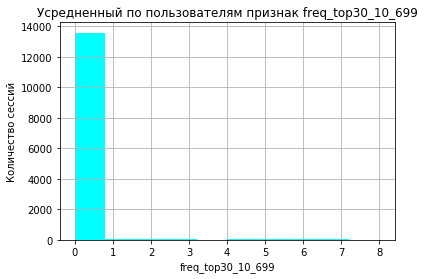

Распределение признака freq_top30_10_699 для каждого пользователя


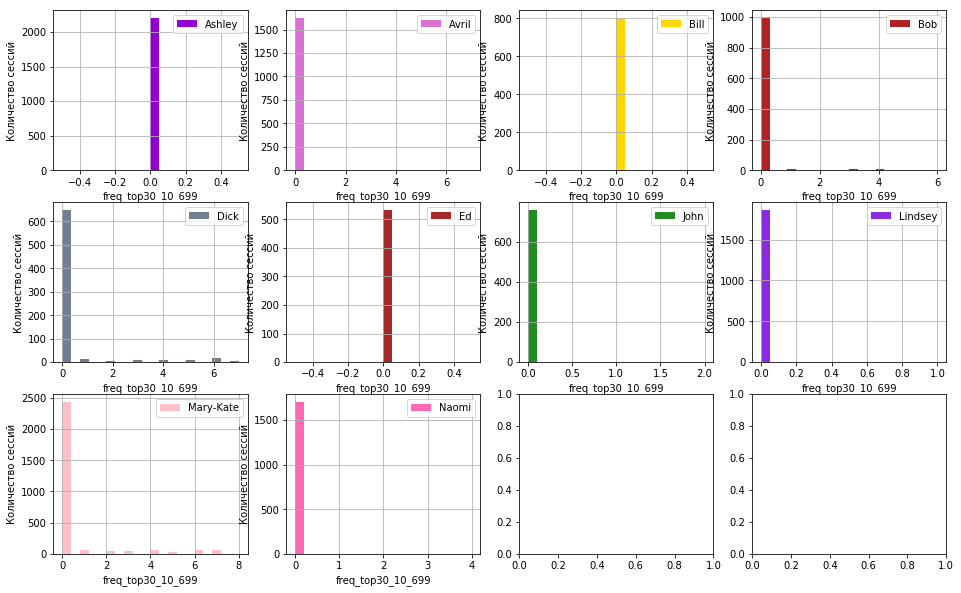

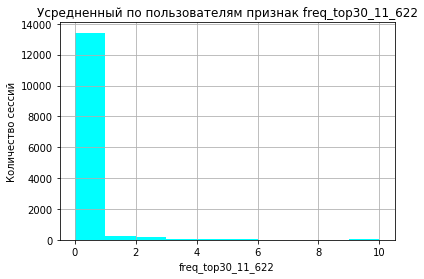

Распределение признака freq_top30_11_622 для каждого пользователя


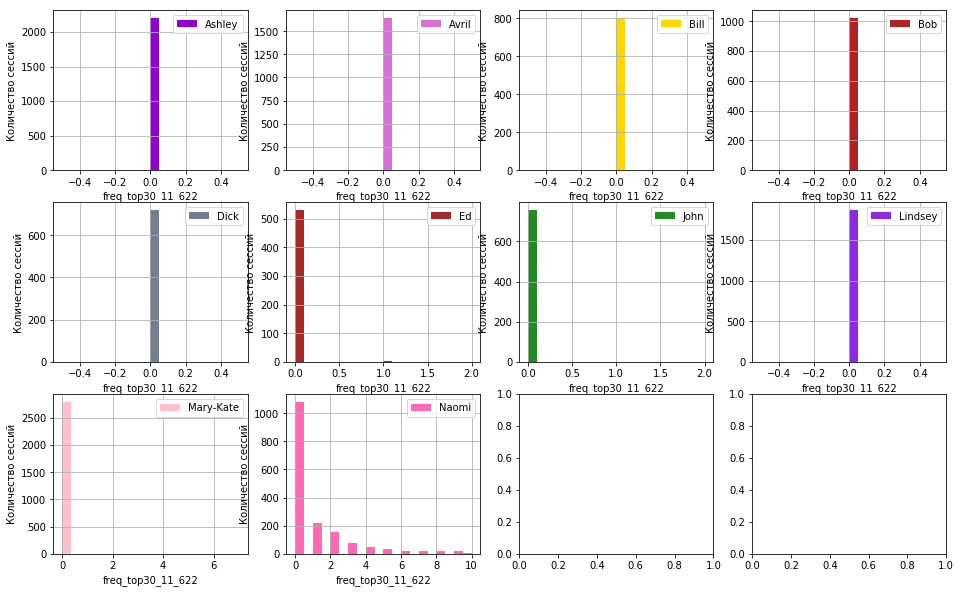

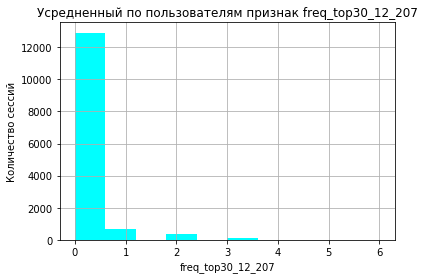

Распределение признака freq_top30_12_207 для каждого пользователя


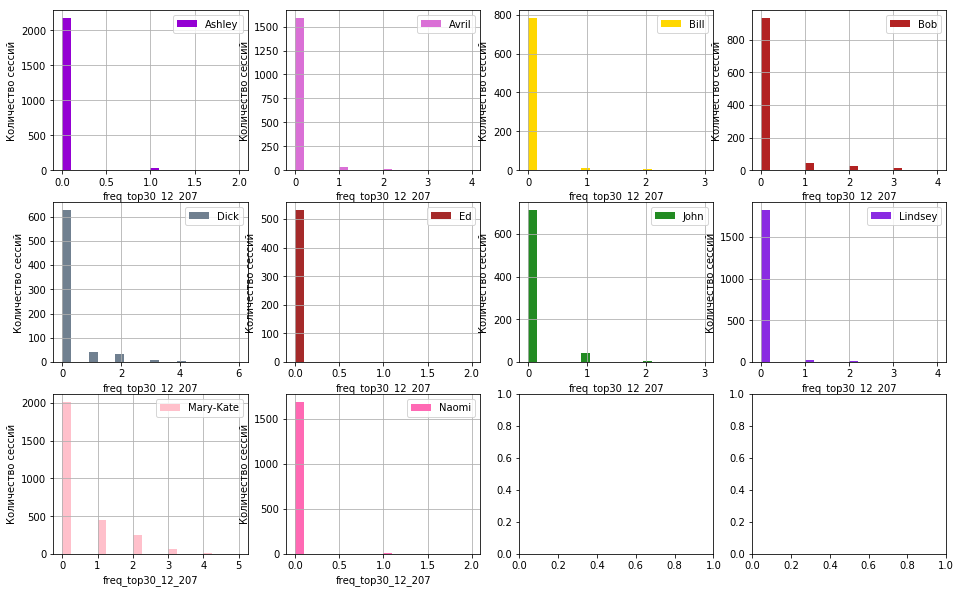

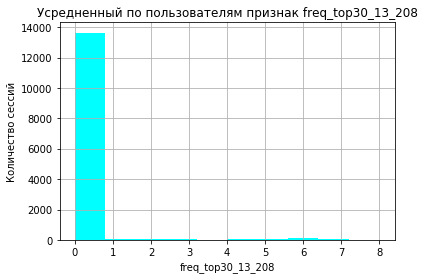

Распределение признака freq_top30_13_208 для каждого пользователя


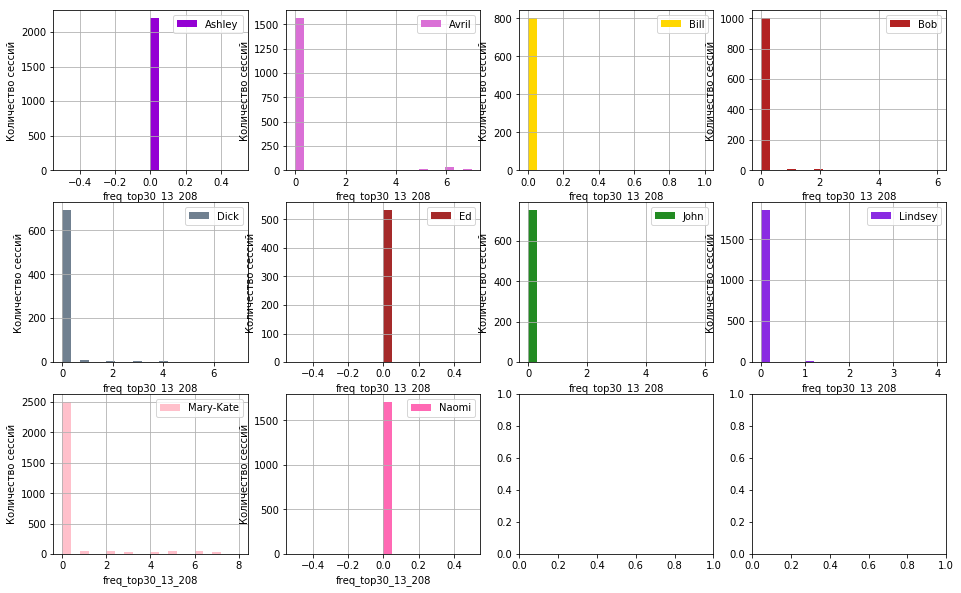

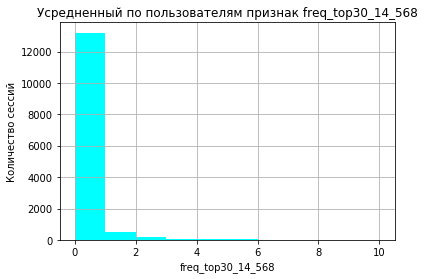

Распределение признака freq_top30_14_568 для каждого пользователя


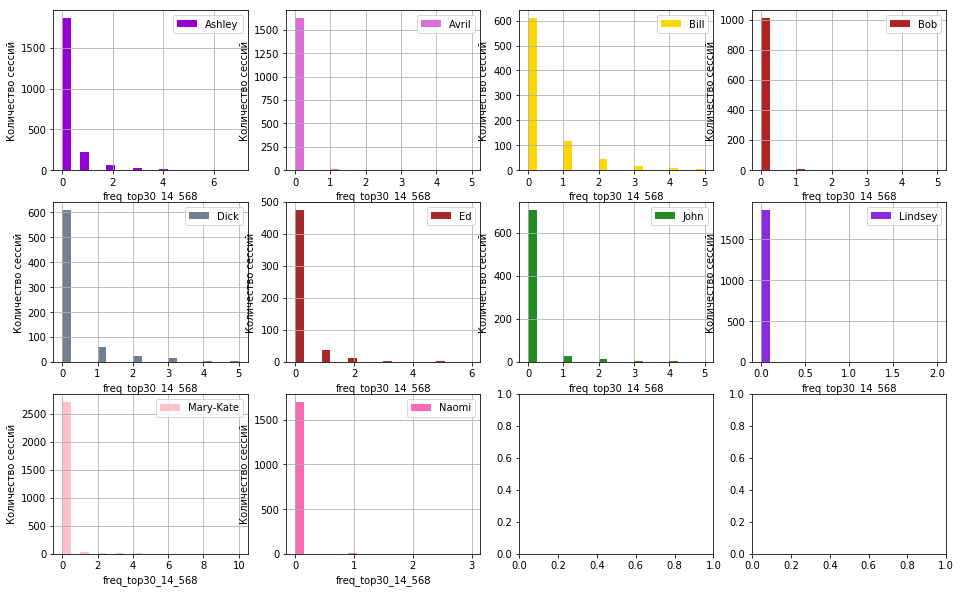

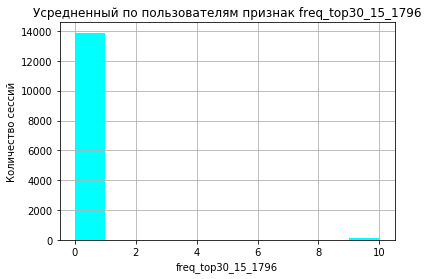

Распределение признака freq_top30_15_1796 для каждого пользователя


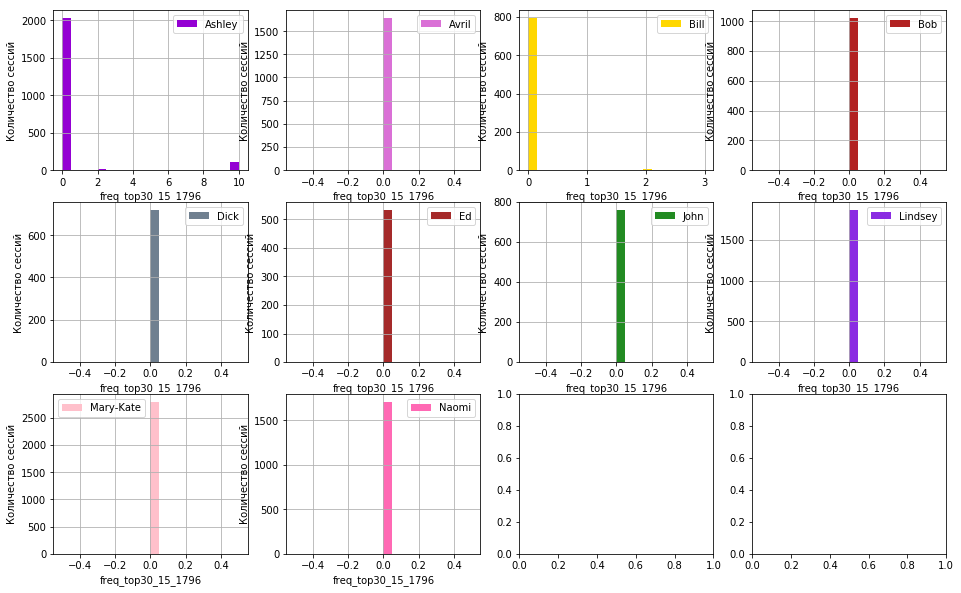

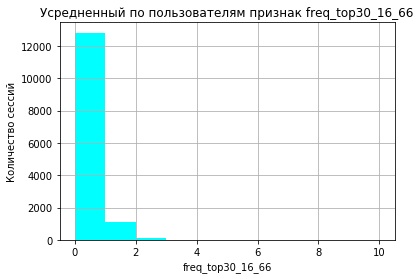

Распределение признака freq_top30_16_66 для каждого пользователя


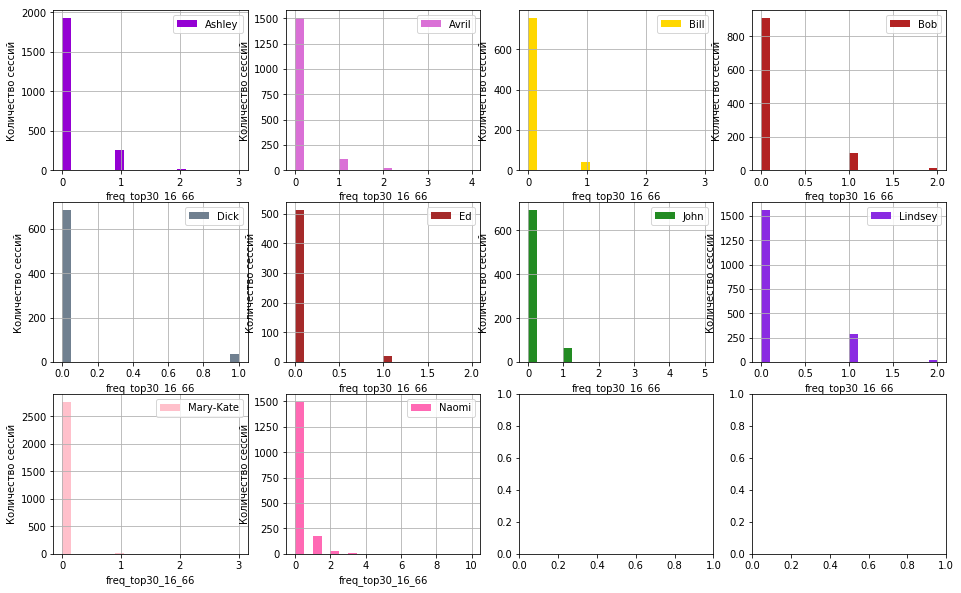

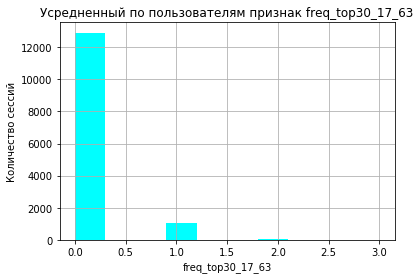

Распределение признака freq_top30_17_63 для каждого пользователя


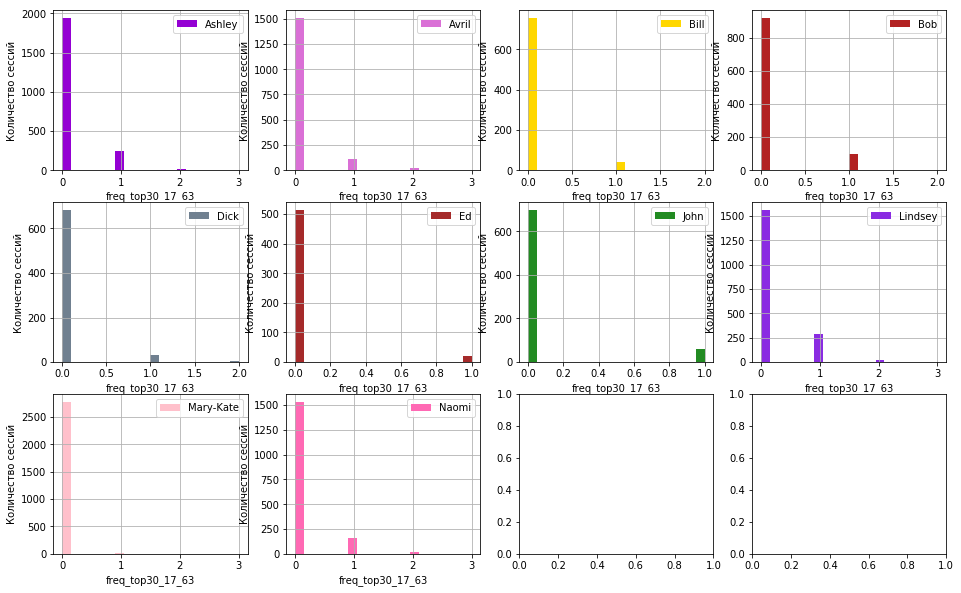

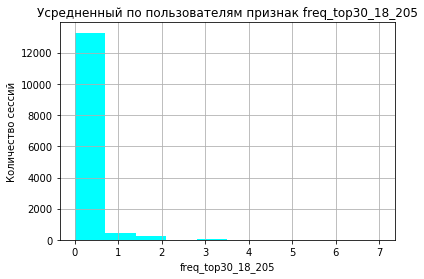

Распределение признака freq_top30_18_205 для каждого пользователя


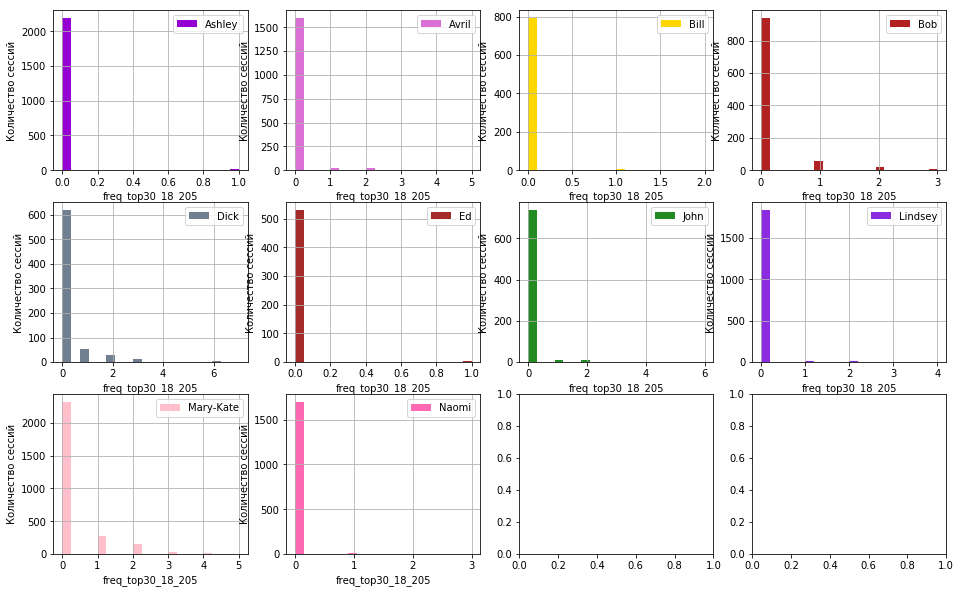

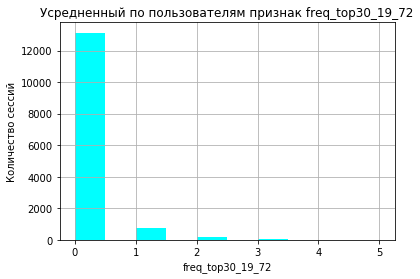

Распределение признака freq_top30_19_72 для каждого пользователя


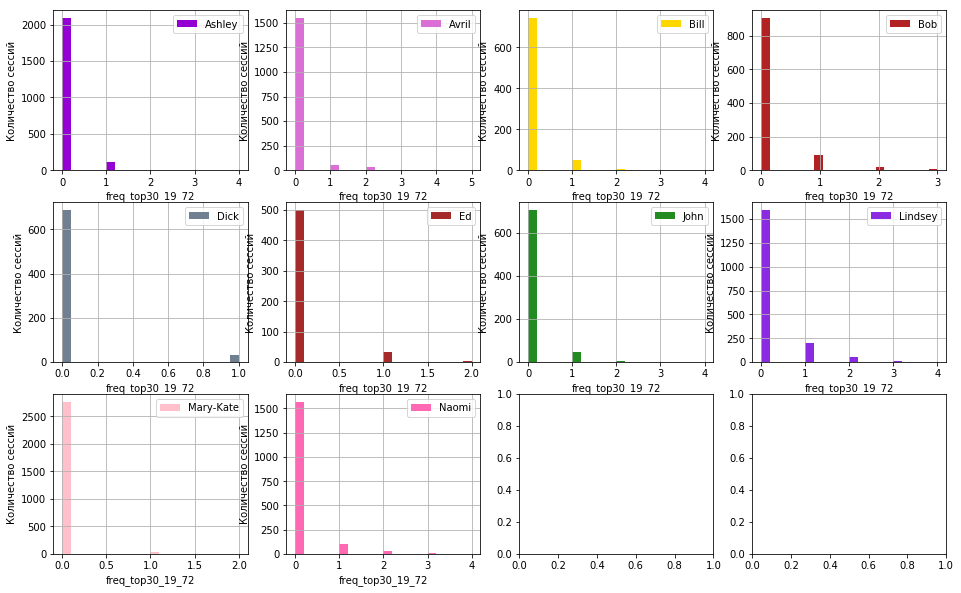

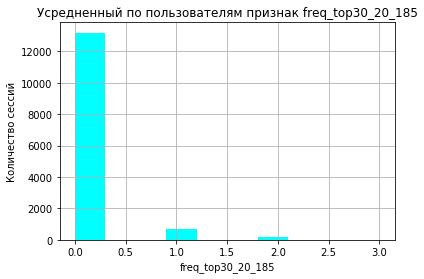

Распределение признака freq_top30_20_185 для каждого пользователя


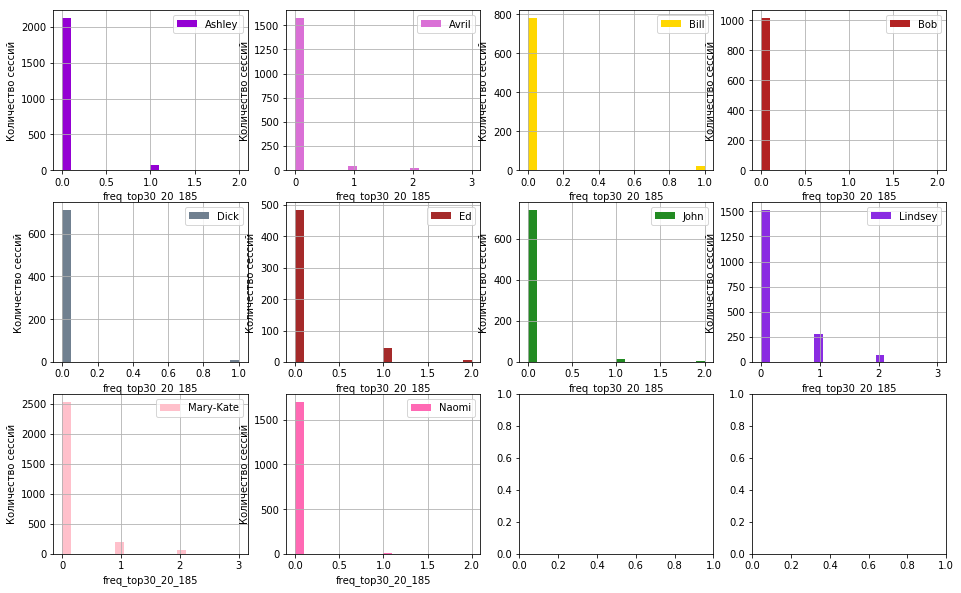

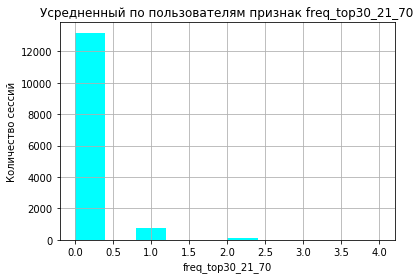

Распределение признака freq_top30_21_70 для каждого пользователя


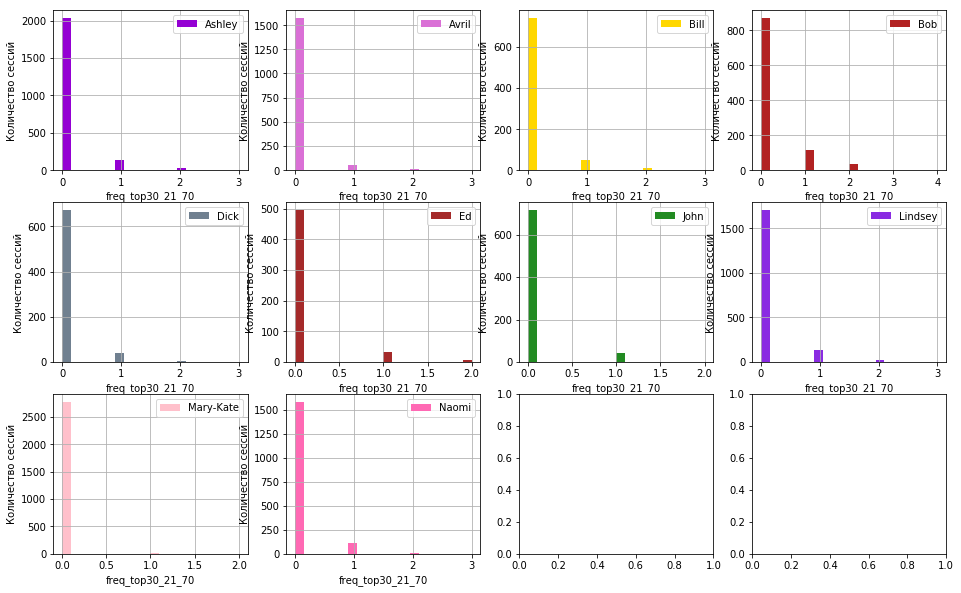

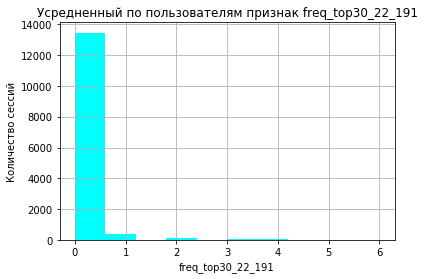

Распределение признака freq_top30_22_191 для каждого пользователя


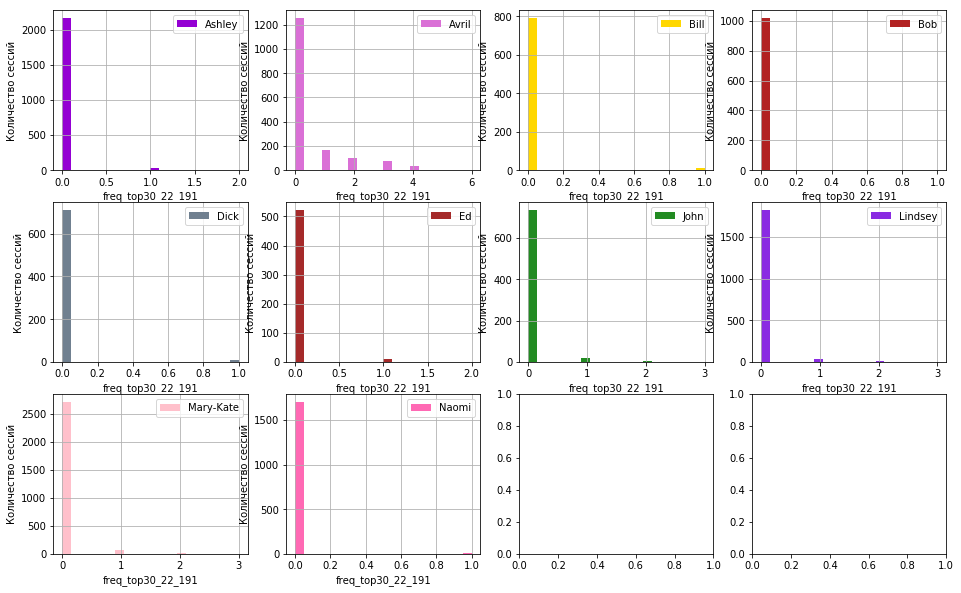

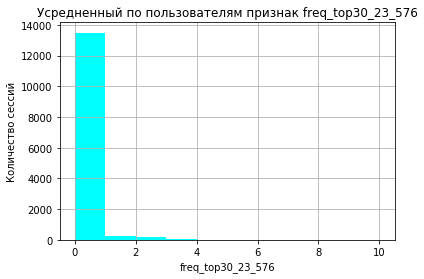

Распределение признака freq_top30_23_576 для каждого пользователя


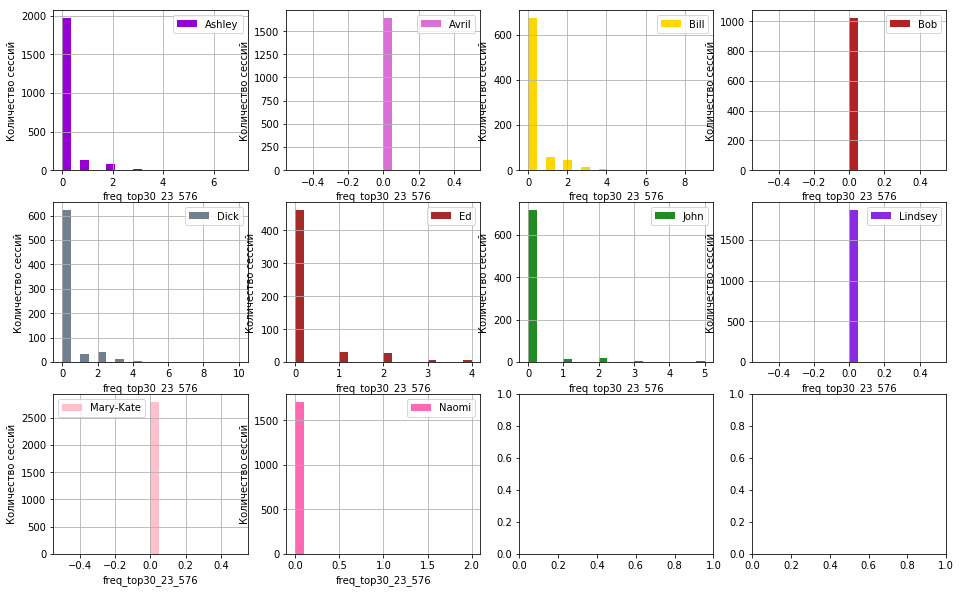

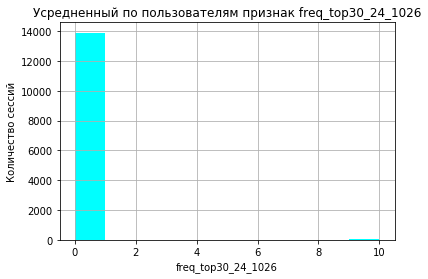

Распределение признака freq_top30_24_1026 для каждого пользователя


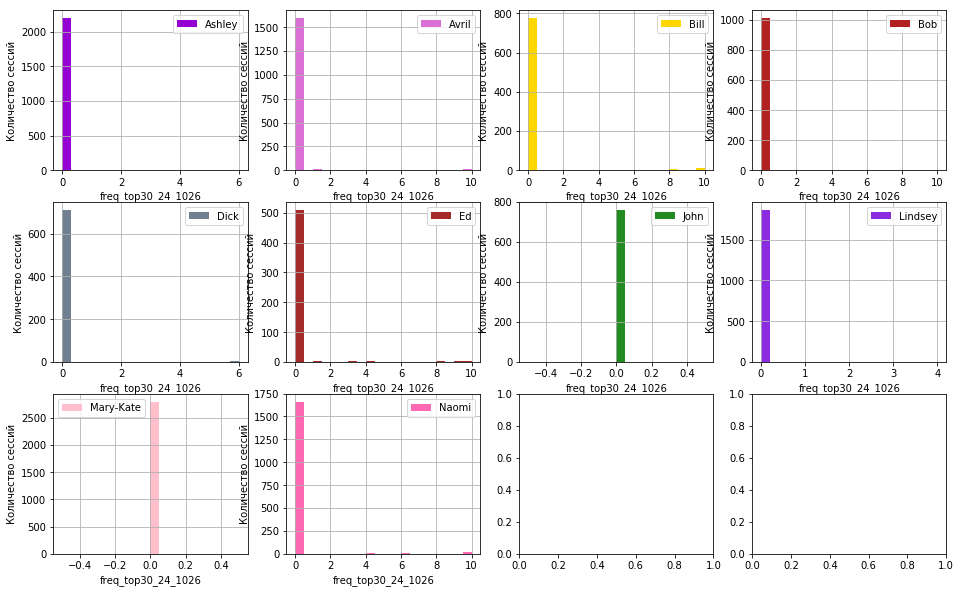

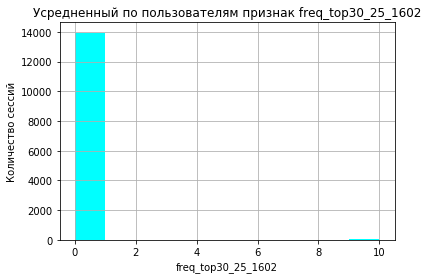

Распределение признака freq_top30_25_1602 для каждого пользователя


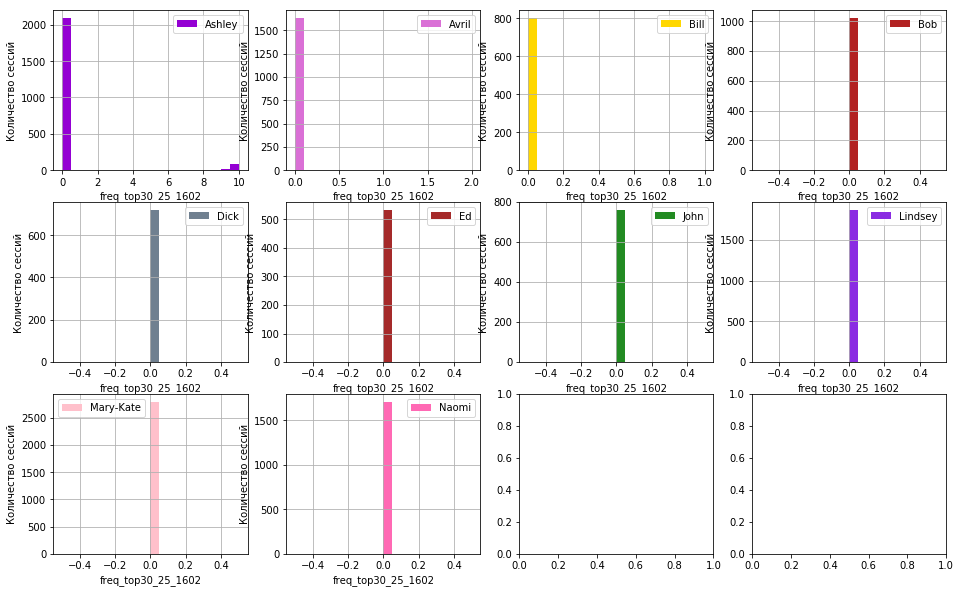

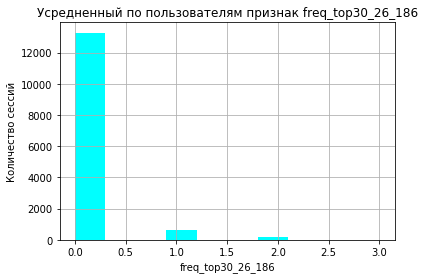

Распределение признака freq_top30_26_186 для каждого пользователя


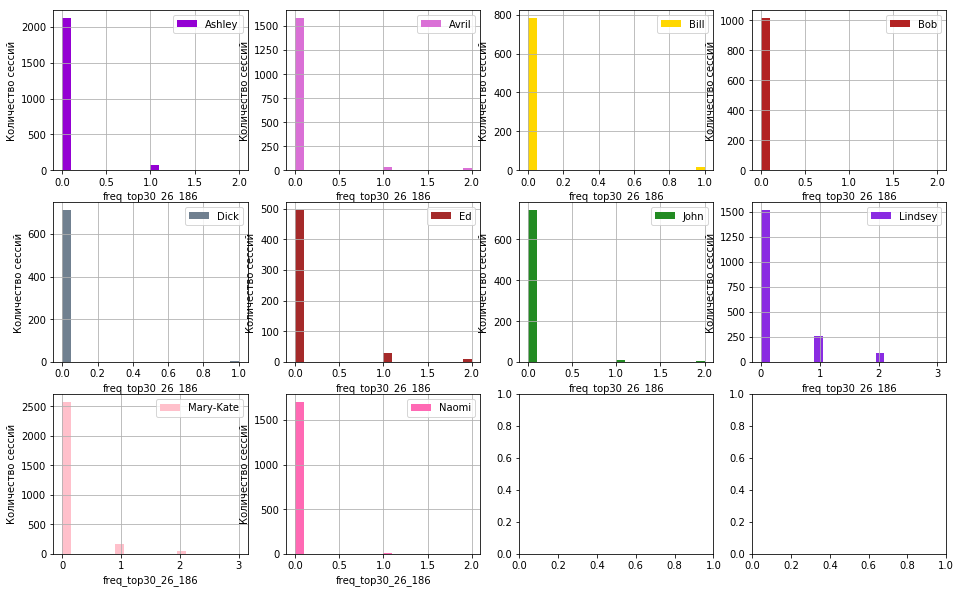

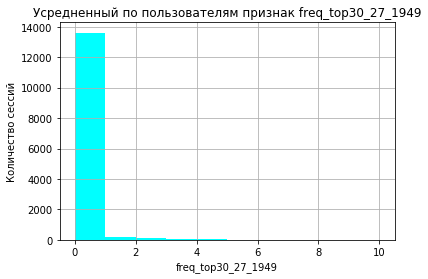

Распределение признака freq_top30_27_1949 для каждого пользователя


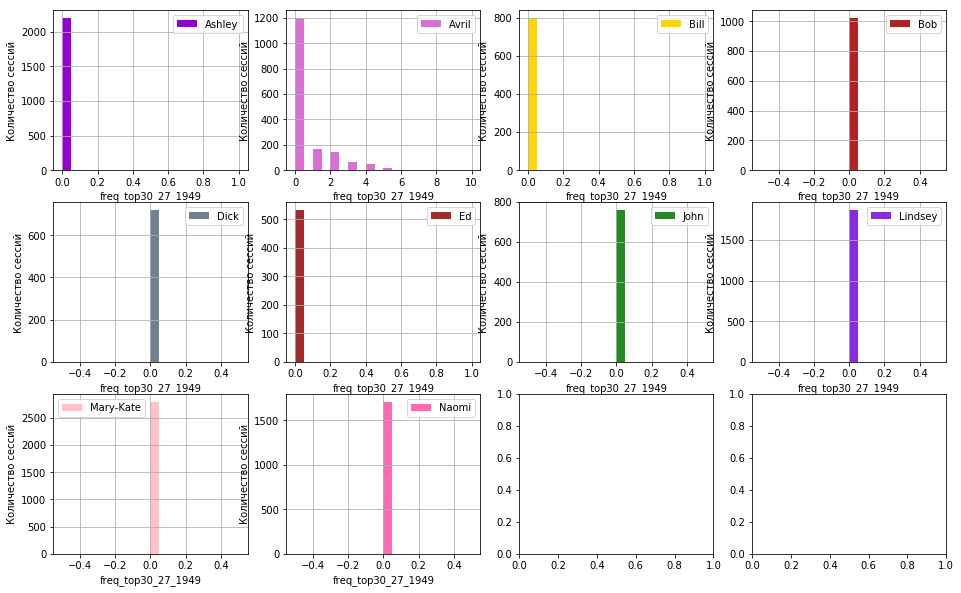

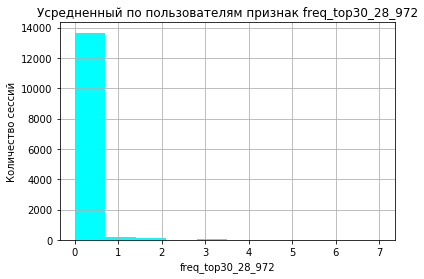

Распределение признака freq_top30_28_972 для каждого пользователя


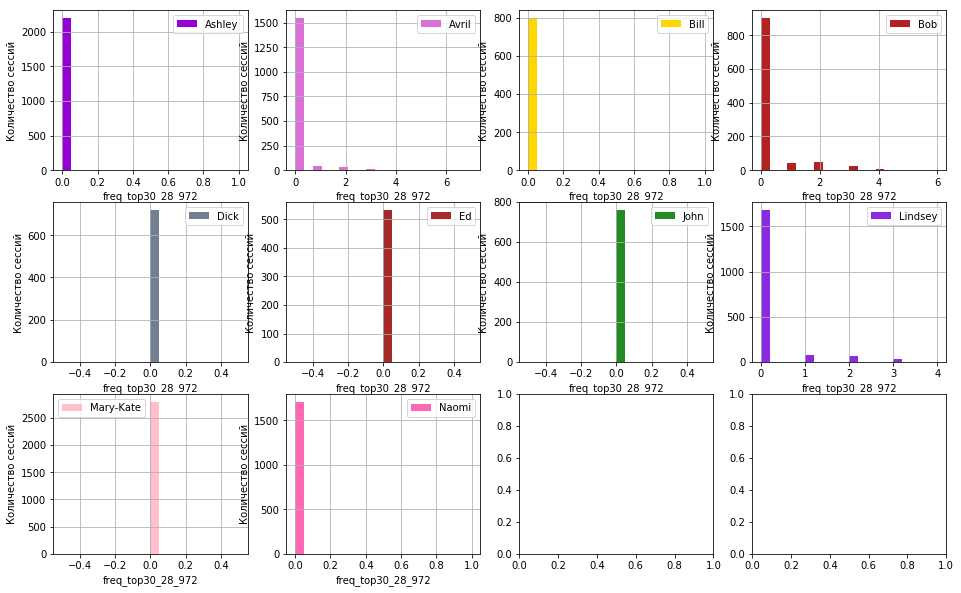

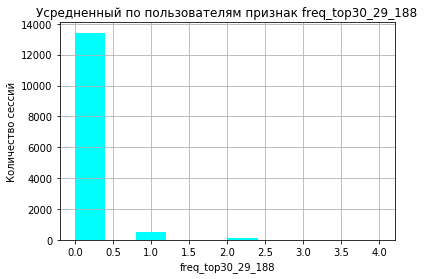

Распределение признака freq_top30_29_188 для каждого пользователя


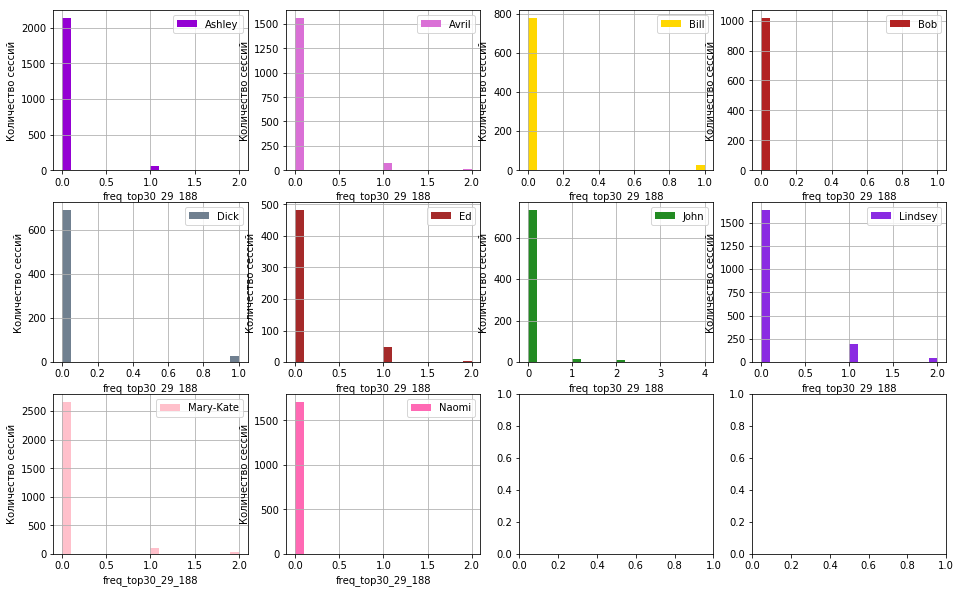

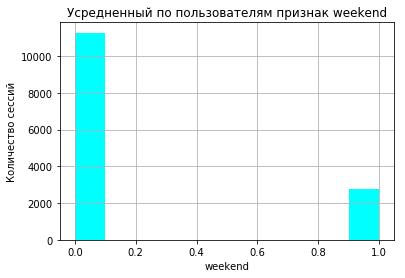

Распределение признака weekend для каждого пользователя


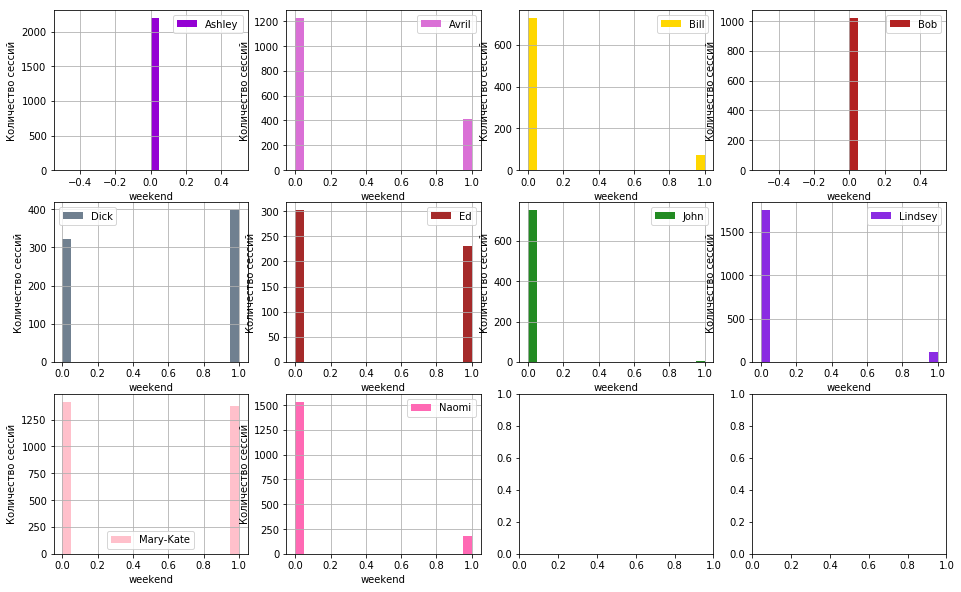

In [43]:
for feature in new_features_10users_s10_w7.columns[:-2]:
    new_features_10users[feature].hist(color='aqua', bins=10)
    plt.title('Усредненный по пользователям признак ' + feature)
    plt.xlabel(feature)
    plt.ylabel('Количество сессий')
    plt.show()

    print('Распределение признака ' + feature + ' для каждого пользователя')

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

    # как вариант, можно и по-другому
    for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
        col = feature
        sub_df[col].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=20)
#                                    bins=(sub_df[col].max() - sub_df[col].min() + 1))
        axes[idx // 4, idx % 4].legend()
    #     axes[idx // 4, idx % 4].set_xlim([1, 10])
        axes[idx // 4, idx % 4].set_xlabel(feature)
        axes[idx // 4, idx % 4].set_ylabel('Количество сессий')

    plt.show()

**АНАЛИЗ:**   
Все признаки, кроме **mean_site_time** - более-менее адекватны. Этот признак, по крайней мере как он выглядит сейчас, пока не внушает доверия. В частности, там иногда встречаются аномально большие значения (как если бы пользователь включил компьютер, зашел на сайт и уехал, например, на работу).    
Посмотрим на этот признак **еще раз** внимательнее, ограничив правый хвост **на 200**:

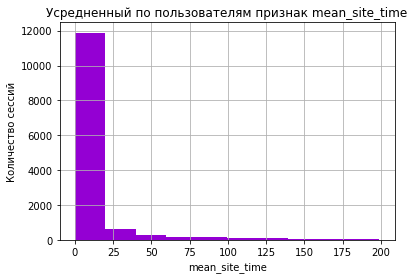

Распределение признака mean_site_time для каждого пользователя


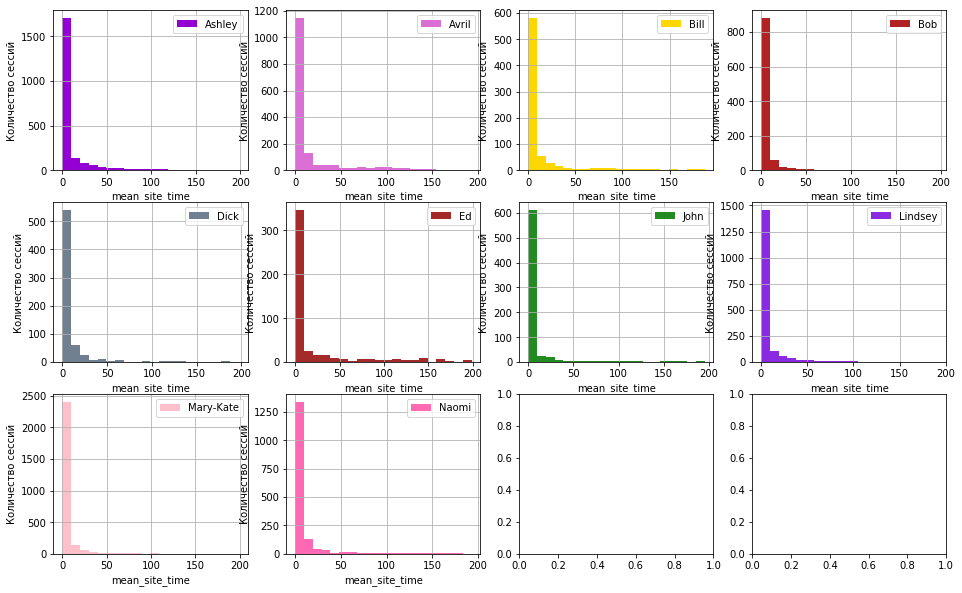

In [44]:
feature = 'mean_site_time'
new_features_10users[feature][new_features_10users[feature] < 200].hist(color='darkviolet', bins=10)
plt.title('Усредненный по пользователям признак ' + feature)
plt.xlabel(feature)
plt.ylabel('Количество сессий')
plt.show()

print('Распределение признака ' + feature + ' для каждого пользователя')

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
for idx, (user, sub_df) in  enumerate(pd.groupby(new_features_10users, 'user_id')): 
    col = feature
    sub_df[col][sub_df[col] < 200].hist(ax=axes[idx // 4, idx % 4], color=color_dic[user], label=user, bins=20)
#                                    bins=(sub_df[col].max() - sub_df[col].min() + 1))
    axes[idx // 4, idx % 4].legend()
#     axes[idx // 4, idx % 4].set_xlim([1, 10])
    axes[idx // 4, idx % 4].set_xlabel(feature)
    axes[idx // 4, idx % 4].set_ylabel('Количество сессий')

plt.show()

**Вывод по "mean_site_time"**: на мой взгляд, этот признак одинаков для разных пользователей и по этой причине не информативный. **Исключим его**.

**ОБЩИЙ ВЫВОД ПО НОВЫМ ПРИЗНАКАМ:**   
Признак "**mean_site_time**" - не информативен и исключается.   
Остальные признаки более или менее характеризуют целевой признак. На этом этапе пока не вижу необходимости на основе визуального анализа что-то еще убирать. Возможно, дальше будет виднее.

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

Сформируем также и запишем для дальнейших исследований и такой вариант: **selected_features_10users_s10_w7**

In [45]:
selected_features_10users_list = list(new_features_10users.columns) # список для отбора фич
selected_features_10users_list.remove('mean_site_time') # удаляем фичу 'mean_site_time'

selected_features_150users_list = list(new_features_150users.columns) # список для отбора фич
selected_features_150users_list.remove('mean_site_time') # удаляем фичу 'mean_site_time'

selected_features_10users_s10_w7_list = list(new_features_10users_s10_w7.columns) # список для отбора фич
selected_features_10users_s10_w7_list.remove('mean_site_time') # удаляем фичу 'mean_site_time'

In [46]:
# сохраняем отобранные признаки
selected_features_10users = new_features_10users[selected_features_10users_list].iloc[:, :-2]
selected_features_150users = new_features_150users[selected_features_150users_list].iloc[:, :-1]

selected_features_10users_s10_w7 = new_features_10users_s10_w7[selected_features_10users_s10_w7_list].iloc[:, :-2]

In [47]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users_s10_w7.pkl'), 'wb') as selected_features_10users_s10_w7_pkl:
    pickle.dump(selected_features_10users_s10_w7, selected_features_10users_s10_w7_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 